# NLP Project 
Perform topic modeling on YouTube transcripts using unsupervised learning to extract meaningful topics and use them for improved indexing in a RAG system or summarization.

In [1]:
# imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re 
import pyarabic.araby as araby
from nltk.corpus import stopwords
import nltk
from typing import List
from tqdm.notebook import tqdm
import arabic_reshaper 
from bidi.algorithm import get_display
import json 
import seaborn as sns


### 1. Data Loading

In [2]:
# Folders
DATA_FOLDERS = ["youtube/Al_Mokhbir_Al_Eqtisadi/raw_data", 'youtube/Da7ee7/raw_data', 'youtube/Fi_Al_Hadaraa/raw_data']
META_DATA = ["youtube/Al_Mokhbir_Al_Eqtisadi/metadata", 'youtube/Da7ee7/metadata', 'youtube/Fi_Al_Hadaraa/metadata']

n = 1000
MOKHBIR_DIR = "./youtube/Al_Mokhbir_Al_Eqtisadi/"
DA7EE7_DIR = "./youtube/Da7ee7/"
HADARAA_DIR = "./youtube/Fi_Al_Hadaraa/"

In [3]:
# Create a code that renames the files in the Da7ee7/meta_data folder to remove the _annotation part of the file name
def rename_files():
    for i in range(len(META_DATA)):
        for filename in os.listdir(META_DATA[i]):
            if filename.endswith(".json"):
                new_filename = filename.replace("_annotation", "")
                os.rename(META_DATA[i] + '/' + filename, META_DATA[i] + '/' + new_filename)
    return "Files renamed successfully"

# rename_files()

In [4]:
def data_loader(dir_path: str, n: int, read_metadata: bool = False, tags: str = "keywords", creator: str = "") -> pd.DataFrame:
    """
    Load episode transcripts from text files and optionally add metadata.

    :param dir_path: Path to the directory containing 'raw_data' and 'metadata' folders.
    :param n: Number of episodes to read.
    :param read_metadata: Whether to include metadata from JSON files.
    :return: A pandas DataFrame.
    """
    data_dir_path = os.path.join(dir_path, "raw_data")
    metadata_dir_path = os.path.join(dir_path, "metadata") if read_metadata else None

    episodes = []
    
    # Read the first `n` .txt files
    txt_files = [file for file in os.listdir(data_dir_path) if file.endswith(".txt")][:n]

    for file in txt_files:
        base_name = file.replace(".txt", "")
        file_path = os.path.join(data_dir_path, file)

        with open(file_path, 'r', encoding="utf-8") as f:
            episode_data = {"file_name": base_name, "episode_transcript": f.read().strip()}

        # Read metadata if needed
        if read_metadata:
            metadata_path = os.path.join(metadata_dir_path, base_name + ".json")
            if os.path.exists(metadata_path):
                with open(metadata_path, 'r', encoding="utf-8") as f:
                    json_file = json.load(f)
                    episode_data["length"] = json_file.get("length", None)
                    episode_data["tags"] = json_file.get(tags, None)
            else:
                episode_data["length"] = None  # Handle missing metadata
                episode_data["tags"] = None

        episodes.append(episode_data)
    df = pd.DataFrame(episodes)
    df['creator'] = creator
    return df

In [5]:
mokhbir_df = data_loader(MOKHBIR_DIR, n, read_metadata=True, creator="Al Mokhbir Al Eqtisadi")
da7ee7_df = data_loader(DA7EE7_DIR, n, read_metadata=True, tags="Categories", creator="Da7ee7")
hadaraa_df = data_loader(HADARAA_DIR, n, read_metadata=True, creator="Fi Al Hadaraa")
mokhbir_df.info(), da7ee7_df.info(), hadaraa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   file_name           222 non-null    object
 1   episode_transcript  222 non-null    object
 2   length              222 non-null    object
 3   tags                222 non-null    object
 4   creator             222 non-null    object
dtypes: object(5)
memory usage: 8.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   file_name           145 non-null    object
 1   episode_transcript  145 non-null    object
 2   length              0 non-null      object
 3   tags                145 non-null    object
 4   creator             145 non-null    object
dtypes: object(5)
memory usage: 5.8+ KB
<class 'pandas.core.frame.DataFrame'>
Ra

(None, None, None)

In [6]:
# View mokhbir_df data
mokhbir_df.head()


file_name  \
0  المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل...   
1  المخبر_الاقتصادي__كيف_ترفع_الشركات_أسعار_المن...   
2  المخبر_الاقتصادي__لماذا_تبيع_الصين_كميات_كبيرة...   
3  المخبر_الاقتصادي__لماذا_سترتفع_أسعار_تذاكر_ال...   
4  المخبر_الاقتصادي__لماذا_تخفي_أمريكا_السلاح_ال...   

                                  episode_transcript    length  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  00:22:52   
1  في اواخر 2016 حصل هجوم كبير من\nالمستهلكين في ...  00:15:12   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  00:16:53   
3  في شهر مايو اللي فات\n23 شركة طيران\nأعلنوا إن...  00:14:23   
4  في صباح يوم 19 اكتوبر 2023 الرئيس\nالامريكي جو...  00:20:25   

                                                tags                 creator  
0  [اسرائيل, اشرف ابراهيم, البرلمان البريطاني, ال...  Al Mokhbir Al Eqtisadi  
1  [أحجام المنتجات وأسعارها, أسعار المنتجات ترتفع...  Al Mokhbir Al Eqtisadi  
2  [أمريكا, أوروبا, اشرف ابراهيم, البنك المركزي ا...  Al Mokhbir Al Eqtisadi  
3  [Airlines, fly, tickets, أسعار التذاكر, الخطوط...  Al Mokhbir Al Eqtisadi  
4  [AJ+, AJ+ الدحيح, AJ+ عربي, AJ+ كبريت, AJ+ مع ...  Al Mokhbir Al Eqtisadi

In [7]:
# View da7ee7_df data
da7ee7_df.head()

file_name  \
0  ماذا قال الدحيح عن مقاييس الجمال و الأتيكيت؟ ...   
1                                    النسيان  الدحيح   
2                                     الهاكر  الدحيح   
3                                    الخنزير  الدحيح   
4                              علاقات عن بعد  الدحيح   

                                  episode_transcript length  \
0  4.95: [موسيقى]\n59.42: [موسيقى]\n68.39: [موسيق...   None   
1  2.431: أنا خايف يا دكتور!\n4.554: ما يمكن أنسى...   None   
2  4.742: معلش يا حاج،\nالـ"ليفل سيكيوريتي" بتاعه...   None   
3  0.653: !أقسم بالله ما هسيبه غير إمّا يعتذر\n3....   None   
4  1.68: سلمى حبيبي لسه واصل حالا\n5.759: انا مش ...   None   

                                                tags creator  
0  [الدحيح, eldahih, elda7ee7, da7ee7, al daheeh,...  Da7ee7  
1  [الدحيح, eldahih, elda7ee7, da7ee7, al daheeh,...  Da7ee7  
2  [الدحيح, eldahih, elda7ee7, da7ee7, al daheeh,...  Da7ee7  
3  [الدحيح, new media academy الدحيح, eldahih, el...  Da7ee7  
4  [الدحيح, برنامج الدحيح الجديد, حلقة الدحيح, بر...  Da7ee7

In [8]:
# View hadaraa_df data
hadaraa_df.head()

file_name  \
0                                 الوحدة__في_الحضارة   
1                                الشجاعة__في_الحضارة   
2   لماذا_نحتاج_التعلم_بشكل_مستمر_للحفاظ_على_الوظيفة   
3                       فلسفة_نجيب_محفوظ__في_الحضارة   
4  ما_بين_الأمل_ولذة_التوقعات_.._أين_نجد_علاقات...   

                                  episode_transcript    length  \
0  كدا، خلاص!\nما حدش هيعتّبها تاني!\nإيه؟ الوحدة...  00:24:03   
1  والله ما أعرفه!\nإيه دا؟!\nإيه اللي بيحصل هنا ...  00:22:28   
2  دلوقتي المؤسسات والشركات بقت مخليها\nمساله تدر...  00:00:58   
3  اه يا حار تنسوا كل افضالي عليكم اخص\nعليكم\nاف...  00:22:47   
4  ها؟!\nقُلتي إيه يا أم "ميدو"؟\nأنا شايف إن الح...  00:15:03   

                                                tags        creator  
0  [أنا العربي, ANA ALARABY, القصة كاملة, في العم...  Fi Al Hadaraa  
1  [الشجاعة, أنا العربي, انهيار الحضارة, في الحضا...  Fi Al Hadaraa  
2  [أنا العربي, ANA ALARABY, القصة كاملة, في العم...  Fi Al Hadaraa  
3  [أنا العربي, انهيار الحضارة, في الحضارة, Hadha...  Fi Al Hadaraa  
4  [أنا العربي, ANA ALARABY, القصة كاملة, في العم...  Fi Al Hadaraa

In [9]:
# Combine the three dataframes into one
df = pd.concat([mokhbir_df, da7ee7_df, hadaraa_df], ignore_index=True)
df.head()

file_name  \
0  المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل...   
1  المخبر_الاقتصادي__كيف_ترفع_الشركات_أسعار_المن...   
2  المخبر_الاقتصادي__لماذا_تبيع_الصين_كميات_كبيرة...   
3  المخبر_الاقتصادي__لماذا_سترتفع_أسعار_تذاكر_ال...   
4  المخبر_الاقتصادي__لماذا_تخفي_أمريكا_السلاح_ال...   

                                  episode_transcript    length  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  00:22:52   
1  في اواخر 2016 حصل هجوم كبير من\nالمستهلكين في ...  00:15:12   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  00:16:53   
3  في شهر مايو اللي فات\n23 شركة طيران\nأعلنوا إن...  00:14:23   
4  في صباح يوم 19 اكتوبر 2023 الرئيس\nالامريكي جو...  00:20:25   

                                                tags                 creator  
0  [اسرائيل, اشرف ابراهيم, البرلمان البريطاني, ال...  Al Mokhbir Al Eqtisadi  
1  [أحجام المنتجات وأسعارها, أسعار المنتجات ترتفع...  Al Mokhbir Al Eqtisadi  
2  [أمريكا, أوروبا, اشرف ابراهيم, البنك المركزي ا...  Al Mokhbir Al Eqtisadi  
3  [Airlines, fly, tickets, أسعار التذاكر, الخطوط...  Al Mokhbir Al Eqtisadi  
4  [AJ+, AJ+ الدحيح, AJ+ عربي, AJ+ كبريت, AJ+ مع ...  Al Mokhbir Al Eqtisadi

### 2. Data Understanding

In [10]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   file_name           426 non-null    object
 1   episode_transcript  426 non-null    object
 2   length              281 non-null    object
 3   tags                426 non-null    object
 4   creator             426 non-null    object
dtypes: object(5)
memory usage: 16.8+ KB


There are missing values in the `length` column

In [11]:
# Get summary statistics
df.describe()

file_name  \
count                                                 426   
unique                                                426   
top     المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل...   
freq                                                    1   

                                       episode_transcript    length  \
count                                                 426       281   
unique                                                426       225   
top     عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  00:16:15   
freq                                                    1         5   

                                                     tags  \
count                                                 426   
unique                                                401   
top     [أنا العربي, ANA ALARABY, القصة كاملة, في العم...   
freq                                                   11   

                       creator  
count                      426  
unique                       3  
top     Al Mokhbir Al Eqtisadi  
freq                       222

In [12]:
# Check if there are any duplicates
print(f"Number of duplicates: {df['episode_transcript'].duplicated().sum()}")

Number of duplicates: 0


In [13]:
# View the number of missing length values by creator
df[df['length'].isnull()]['creator'].value_counts()

creator
Da7ee7    145
Name: count, dtype: int64

So the `Da7ee7` episodes are the only ones with missing length

In [14]:
# View the number of episodes by creator
df['creator'].value_counts()

creator
Al Mokhbir Al Eqtisadi    222
Da7ee7                    145
Fi Al Hadaraa              59
Name: count, dtype: int64

In the dataset, `Al Mokhbir Al Eqtisadi` has the highest number of episodes

#### Transcript length

In [15]:
# Get the transcript length
df['transcript_length'] = df['episode_transcript'].apply(lambda x: len(x.split()))
df.head()

file_name  \
0  المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل...   
1  المخبر_الاقتصادي__كيف_ترفع_الشركات_أسعار_المن...   
2  المخبر_الاقتصادي__لماذا_تبيع_الصين_كميات_كبيرة...   
3  المخبر_الاقتصادي__لماذا_سترتفع_أسعار_تذاكر_ال...   
4  المخبر_الاقتصادي__لماذا_تخفي_أمريكا_السلاح_ال...   

                                  episode_transcript    length  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  00:22:52   
1  في اواخر 2016 حصل هجوم كبير من\nالمستهلكين في ...  00:15:12   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  00:16:53   
3  في شهر مايو اللي فات\n23 شركة طيران\nأعلنوا إن...  00:14:23   
4  في صباح يوم 19 اكتوبر 2023 الرئيس\nالامريكي جو...  00:20:25   

                                                tags                 creator  \
0  [اسرائيل, اشرف ابراهيم, البرلمان البريطاني, ال...  Al Mokhbir Al Eqtisadi   
1  [أحجام المنتجات وأسعارها, أسعار المنتجات ترتفع...  Al Mokhbir Al Eqtisadi   
2  [أمريكا, أوروبا, اشرف ابراهيم, البنك المركزي ا...  Al Mokhbir Al Eqtisadi   
3  [Airlines, fly, tickets, أسعار التذاكر, الخطوط...  Al Mokhbir Al Eqtisadi   
4  [AJ+, AJ+ الدحيح, AJ+ عربي, AJ+ كبريت, AJ+ مع ...  Al Mokhbir Al Eqtisadi   

   transcript_length  
0               3285  
1               2231  
2               2328  
3               2119  
4               2783

In [16]:
# View the average transcript length by creator
df.groupby('creator')['transcript_length'].mean().sort_values(ascending=False)

creator
Da7ee7                    4694.068966
Fi Al Hadaraa             2999.966102
Al Mokhbir Al Eqtisadi    2511.297297
Name: transcript_length, dtype: float64

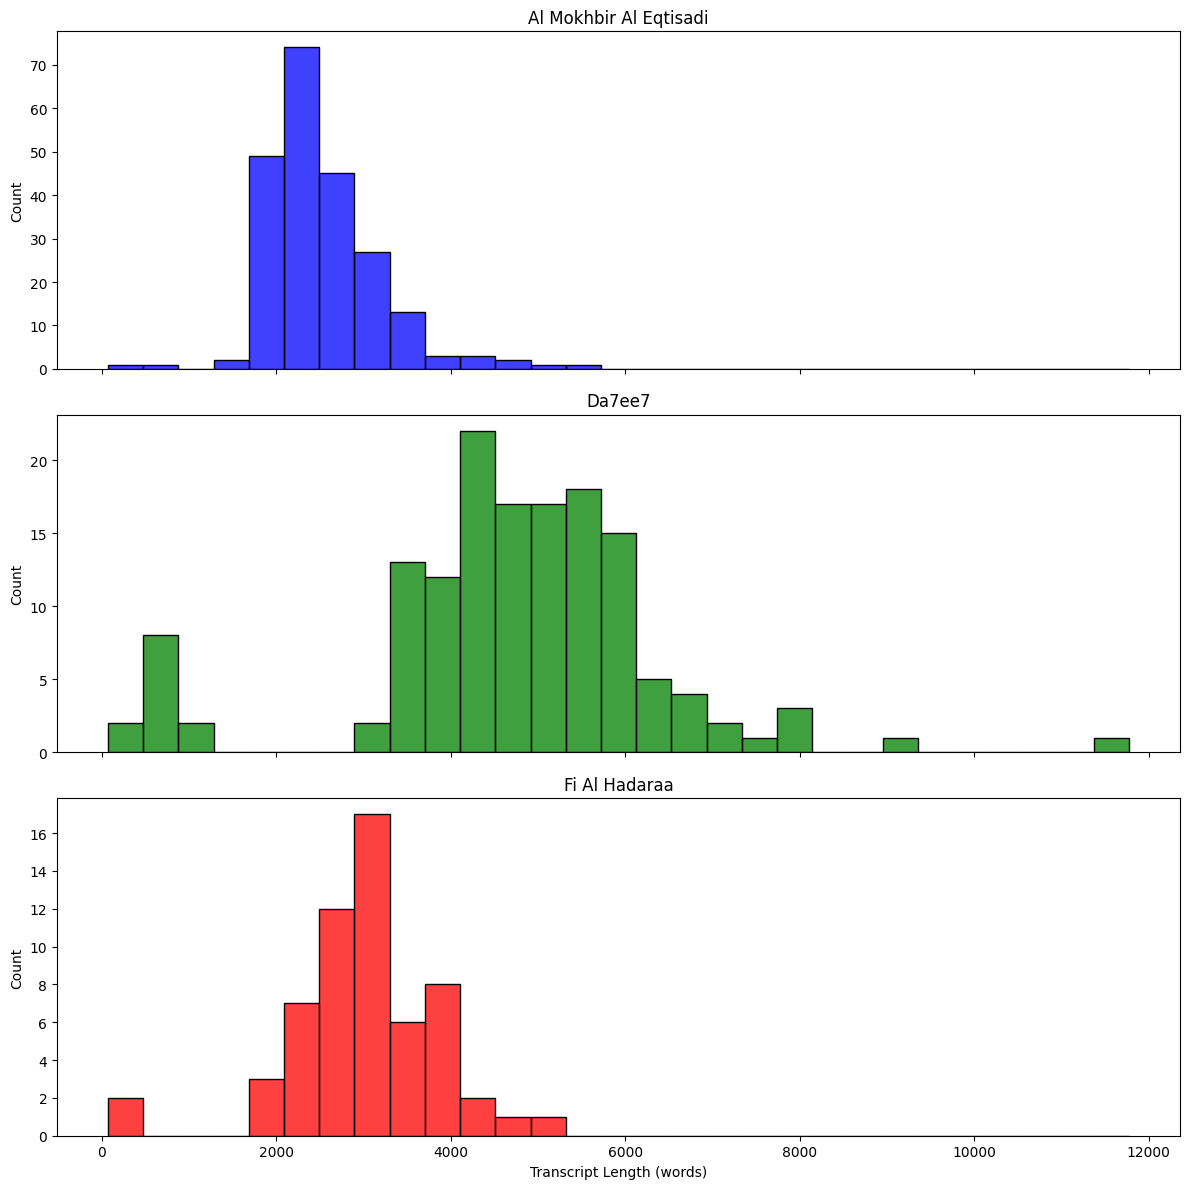

In [17]:
# View the histogram of transcript lengths (word count)
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
plt.subplots_adjust(hspace=0.3)

# Create bins that cover the full range of data (using transcript_length which contains word count)
min_length = df['transcript_length'].min()
max_length = df['transcript_length'].max()
bins = np.linspace(min_length, max_length, 30)

# Plot for each creator
sns.histplot(df[df['creator'] == 'Al Mokhbir Al Eqtisadi']['transcript_length'], ax=axes[0], color='blue', bins=bins)
sns.histplot(df[df['creator'] == 'Da7ee7']['transcript_length'], ax=axes[1], color='green', bins=bins)
sns.histplot(df[df['creator'] == 'Fi Al Hadaraa']['transcript_length'], ax=axes[2], color='red', bins=bins)

axes[0].set_title('Al Mokhbir Al Eqtisadi')
axes[1].set_title('Da7ee7')
axes[2].set_title('Fi Al Hadaraa')

plt.xlabel('Transcript Length (words)')
plt.tight_layout()
plt.show()

`Da7ee7` episodes on average looks to have more words than other creators, hence bigger episodes

In [18]:
# View a couple of samples 
df['episode_transcript'].sample(5).values

array(['في 16 فبراير 2020 وتحديدا في تمام الساعه\n10 ونص جيش الاحتلال الاسرائيلي نشر على\nحسابه على اكس او تويتر تغريده كانت عباره\nعن صوره بدون اي تعليق في الصوره دي كانت\nبتظهر شابه صغيره لابسه توب بدون اكمام\nوماسكه ايفون وبتتصور في المرايه ايه\nعلاقه صوره البنت دي بالجيش الاسرائيلي\nعلشان ينشرها على حسابه الرسمي ما حدش كان\nفاهم حاجه لان الصوره اتنشرت على الحساب\nفجاه بدون اي سياق او تعليق وده عمل جدل\nكبير في التعليقات لحد ما الجيش\nالاسرائيلي طلع بعدها بنص ساعه يبرر نشره\nللصوره دي بانها صوره بتستخدمها حركه حماس\nفي اختراق هواتف الجنود الاسرائيليين لكن\nالتبرير المتاخر وغير المقنع لنشر الصوره\nدي خلى ناس كتير تتهم الجيش الاسرائيلي\nبانه بيتبع الاسلوب الرخيص المعروف باسم\nالفيرست تراب او فخ العطش قلي ما يعرفش\nمنكم اليرست تراب ده هو مصطلح جديد نسبيا\nبيرمز ببساطه عمليه نشر صوره او فيديو على\nالانترنت لشخص ما بهيئه معينه وده بهدف\nاثاره المشاهد او المتلقي جنسيا بحيث يكون\nله موقف ايجابي تجاه صاحبه او صاحب الصوره\nاو الفيديو المنشور المهم بعد الحادثه دي\nبحوالي سنه وثلاث شهور تقريبا

#### Correlation between transcript length and actual episode length
- for Mokhbir El Eqtisadi and Fi Al Hadaraa only (no length in Da7ee7 metadata)

In [19]:
def parse_length(length:str):
    """
    Parse the length of the episode from the metadata
    :param length: the length of the episode as a string in the format 'hh:mm:ss'
    :return: the length in seconds
    """
    if pd.isnull(length):
        return None
    h, m, s = map(int, length.split(':'))
    return int(h * 3600 + m * 60 + s)

In [20]:
df['length'] = df['length'].apply(parse_length)
df.head()

file_name  \
0  المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل...   
1  المخبر_الاقتصادي__كيف_ترفع_الشركات_أسعار_المن...   
2  المخبر_الاقتصادي__لماذا_تبيع_الصين_كميات_كبيرة...   
3  المخبر_الاقتصادي__لماذا_سترتفع_أسعار_تذاكر_ال...   
4  المخبر_الاقتصادي__لماذا_تخفي_أمريكا_السلاح_ال...   

                                  episode_transcript  length  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  1372.0   
1  في اواخر 2016 حصل هجوم كبير من\nالمستهلكين في ...   912.0   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  1013.0   
3  في شهر مايو اللي فات\n23 شركة طيران\nأعلنوا إن...   863.0   
4  في صباح يوم 19 اكتوبر 2023 الرئيس\nالامريكي جو...  1225.0   

                                                tags                 creator  \
0  [اسرائيل, اشرف ابراهيم, البرلمان البريطاني, ال...  Al Mokhbir Al Eqtisadi   
1  [أحجام المنتجات وأسعارها, أسعار المنتجات ترتفع...  Al Mokhbir Al Eqtisadi   
2  [أمريكا, أوروبا, اشرف ابراهيم, البنك المركزي ا...  Al Mokhbir Al Eqtisadi   
3  [Airlines, fly, tickets, أسعار التذاكر, الخطوط...  Al Mokhbir Al Eqtisadi   
4  [AJ+, AJ+ الدحيح, AJ+ عربي, AJ+ كبريت, AJ+ مع ...  Al Mokhbir Al Eqtisadi   

   transcript_length  
0               3285  
1               2231  
2               2328  
3               2119  
4               2783

In [21]:
# Check the distribution of episode lengths
df['length'].describe()

count     281.000000
mean     1076.032028
std       272.993568
min        35.000000
25%       909.000000
50%      1030.000000
75%      1213.000000
max      2404.000000
Name: length, dtype: float64

##### Calculate and plot correlation

Correlation : 0.9125319204169177


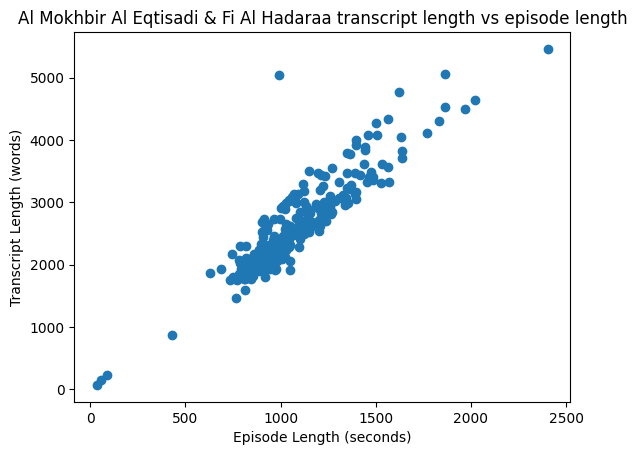

In [22]:
corr = df['length'].corr(df['transcript_length'])
print(f"Correlation : {corr}")

plt.scatter(df['length'], df['transcript_length'])
plt.xlabel('Episode Length (seconds)')
plt.ylabel('Transcript Length (words)')
plt.title('Al Mokhbir Al Eqtisadi & Fi Al Hadaraa transcript length vs episode length')
plt.show()



The High Correlation between the transcript length and the actual episode length is expected, as the transcript length is a good indicator of the episode length in general.

#### Non Arabic Words Analysis

In [23]:
# Check the number of non-arabic words
def count_non_arabic_words(text: str) -> int:
    """
    Count the number of non-arabic words in a text, that are also not a number
    """
    non_arabic_words = 0
    for word in text.split():
        if re.search(r'[a-zA-Z]', word):
            non_arabic_words += 1
    return non_arabic_words

In [24]:
# Apply the function
df['non_arabic_words'] = df['episode_transcript'].apply(count_non_arabic_words)
df['non_arabic_words'].sum()

14689

In all the episodes there are 14689 english words being used

In [25]:
# View the number of non-arabic words by creator
df.groupby('creator')['non_arabic_words'].mean()

creator
Al Mokhbir Al Eqtisadi     8.076577
Da7ee7                    83.331034
Fi Al Hadaraa             13.779661
Name: non_arabic_words, dtype: float64

`Da7ee7` uses a lot of english words in his episodes compared to the other 2 creators.

In [26]:
# View the second max number of non-arabic words for da7ee7
df[df['creator'] == 'Da7ee7']['non_arabic_words'].nlargest(2)

246    3040
232     381
Name: non_arabic_words, dtype: int64

In [27]:
# View the da7ee7 episode with the 3040 non-arabic words
df[(df['creator'] == 'Da7ee7') & (df['non_arabic_words'] == 3040)]

file_name                                 episode_transcript  \
246  إنترفيو  الدحيح  2.52: Here he goes reading my CV,\n5.146: he'l...   

     length                                               tags creator  \
246     NaN  [الدحيح, حلقة الدحيح, برنامج الدحيح الجديد, بر...  Da7ee7   

     transcript_length  non_arabic_words  
246               3473              3040

This looks to be a wrong entry in the dataset, as going into the original episode on youtube [Link](https://www.youtube.com/watch?v=YnTEXW7RaYY) is arabic, however this seems like an english version so we will drop this entry 

In [28]:
# Drop the episode with non_arabic_words = 3040
df = df[df['non_arabic_words'] != 3040].reset_index(drop=True)
print(f"Removed entry with 3040 non-Arabic words. Remaining data: {len(df)} rows")


Removed entry with 3040 non-Arabic words. Remaining data: 425 rows


In [29]:
# View the new number of non-arabic words by creator
df.groupby('creator')['non_arabic_words'].mean()

creator
Al Mokhbir Al Eqtisadi     8.076577
Da7ee7                    62.798611
Fi Al Hadaraa             13.779661
Name: non_arabic_words, dtype: float64

After removing the irregular entry, it seems like `Da7ee7` has still more english words used in his episodes

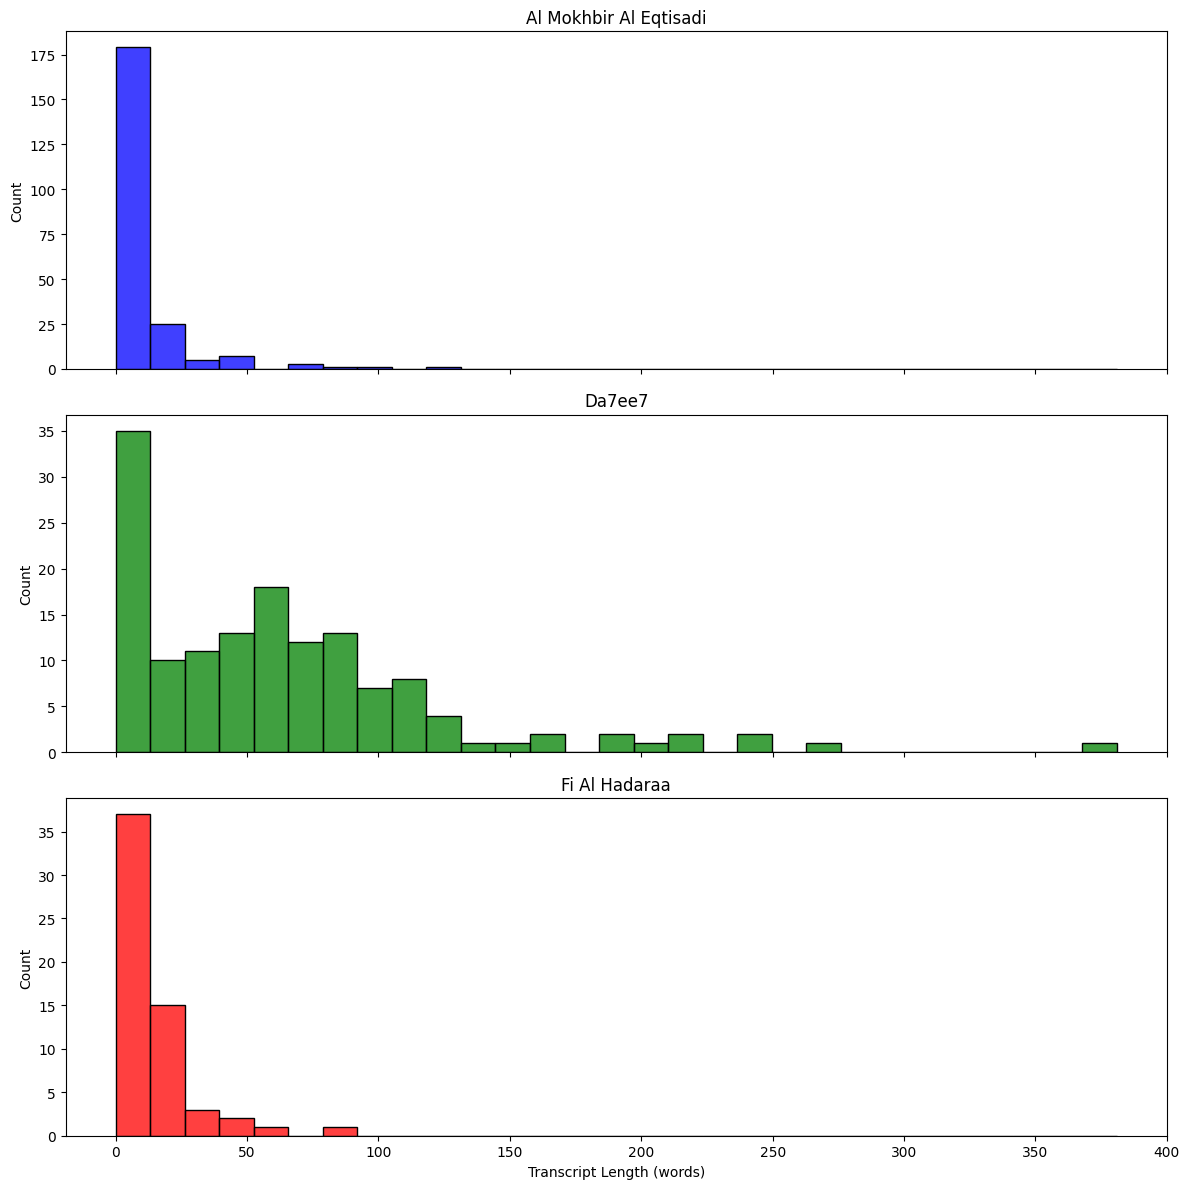

In [30]:
# View the histogram of transcript lengths (word count)
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
plt.subplots_adjust(hspace=0.3)

# Create bins that cover the full range of data (using transcript_length which contains word count)
min_length = df['non_arabic_words'].min()
max_length = df['non_arabic_words'].max()
bins = np.linspace(min_length, max_length, 30)

# Plot for each creator
sns.histplot(df[df['creator'] == 'Al Mokhbir Al Eqtisadi']['non_arabic_words'], ax=axes[0], color='blue', bins=bins)
sns.histplot(df[df['creator'] == 'Da7ee7']['non_arabic_words'], ax=axes[1], color='green', bins=bins)
sns.histplot(df[df['creator'] == 'Fi Al Hadaraa']['non_arabic_words'], ax=axes[2], color='red', bins=bins)

axes[0].set_title('Al Mokhbir Al Eqtisadi')
axes[1].set_title('Da7ee7')
axes[2].set_title('Fi Al Hadaraa')

plt.xlabel('Transcript Length (words)')
plt.tight_layout()
plt.show()

After plotting the graphs, it seems that `Da7ee7` uses a lot of english words, that could be because he always talk in english terminology.

##### Word Clouds & Phrase Clouds for English Words

In [31]:
from wordcloud import WordCloud
from collections import Counter
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))

def extract_non_arabic_words(text, remove_stopwords=False):
    """
    Extracts non-Arabic words from text, removes punctuation, and optionally filters stopwords.

    Parameters:
    - text (str): The input text.
    - remove_stopwords (bool): Whether to remove English stopwords (default: False).

    Returns:
    - List of cleaned non-Arabic words.
    """
    words = text.split()
    
    # Keep words with Latin characters and remove punctuation
    non_arabic = [re.sub(r'[^a-zA-Z]', '', word).lower() for word in words if re.search(r'[a-zA-Z]', word)]
    
    # Remove empty strings
    non_arabic = list(filter(None, non_arabic))
    
    # Optionally remove stopwords
    if remove_stopwords:
        non_arabic = [word for word in non_arabic if word not in english_stopwords]

    return non_arabic

def generate_non_arabic_wordcloud(df, column_name, remove_stopwords=False):
    """
    Generates a word cloud for non-Arabic words in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing text data.
    - column_name (str): The name of the column containing text.
    - remove_stopwords (bool): Whether to remove English stopwords (default: False).
    """
    # Extract non-Arabic words from the specified column
    non_arabic_words = df[column_name].dropna().apply(lambda x: extract_non_arabic_words(x, remove_stopwords)).tolist()
    
    # Flatten the list
    flattened_words = [word for sublist in non_arabic_words for word in sublist]
    
    # Count word frequencies
    word_freq = Counter(flattened_words)
    
    # Generate the word cloud from frequencies
    wordcloud = WordCloud(width=800, 
                          height=800, 
                          background_color='white', 
                          min_font_size=10).generate_from_frequencies(word_freq)

    # Display the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/karimgamaleldin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


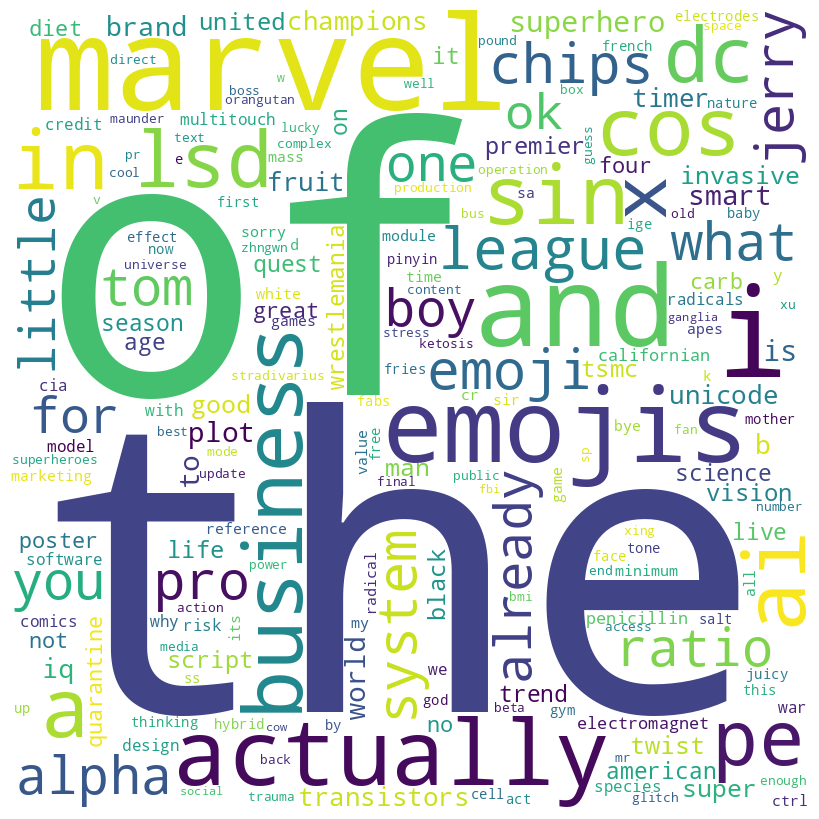

In [32]:
generate_non_arabic_wordcloud(df[df['creator'] == 'Da7ee7'], column_name='episode_transcript', remove_stopwords=False)

- Words like "the", "to", "and", "you", "in", and "of" are highly prominent.
- These are common English stopwords, which do not add much value to analysis.

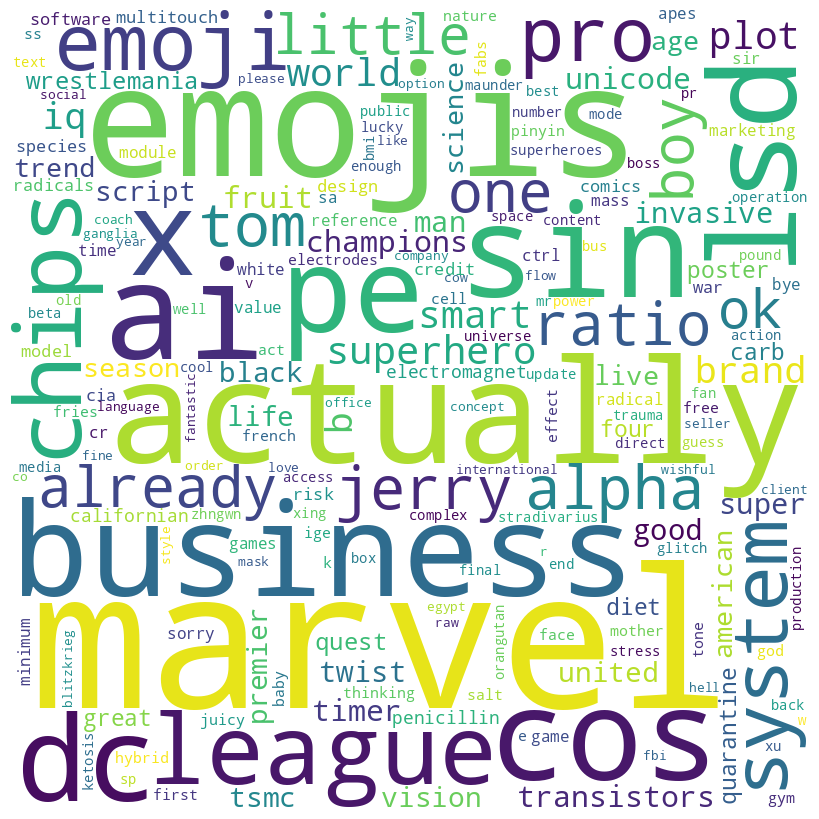

In [33]:
generate_non_arabic_wordcloud(df[df['creator'] == 'Da7ee7'], column_name='episode_transcript', remove_stopwords=True)

**Analysis of Non-Arabic Words in Da7ee7's Word Cloud**

**1. Science & Technology Terms**  
- The word cloud includes multiple references to **science, mathematics, and technology**, such as:  
  - **AI, system, chips, transistors, electromagnet, Unicode, multitouch, electrode, module**.  
- The presence of **sin, cos, alpha, ratio** suggests discussions on **mathematics and physics concepts**.

**2. Business & Economics**  
- Several terms relate to **business, economics, and marketing**, including:  
  - **business, brand, marketing, company, production, software, trend, industry**.  
- Words like **ratio and value** may indicate references to **finance or investment discussions**.

**3. Pop Culture & Entertainment**  
- A significant number of terms are associated with **movies, comics, and media**, such as:  
  - **Marvel, DC, superhero, champions, universe, plot, twist, reference**.  
- Names like **Tom & Jerry** and **WrestleMania** highlight references to **cartoons, wrestling, and entertainment culture**.

**4. Internet & Social Media Language**  
- Common words in **internet and meme culture** appear, including:  
  - **emoji, emojis, ratio, ok, already, good, little, actually**.  
- The inclusion of **ctrl, script, update** suggests references to **programming and digital interfaces**.

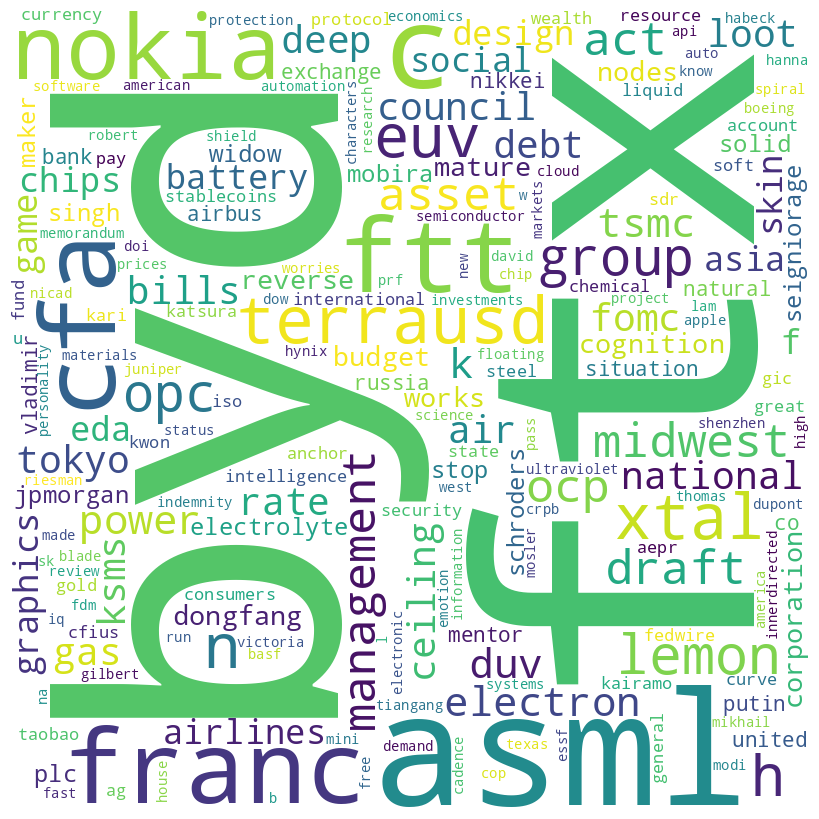

In [34]:
generate_non_arabic_wordcloud(df[df['creator'] == 'Al Mokhbir Al Eqtisadi'], column_name='episode_transcript', remove_stopwords=True)

**Analysis of Non-Arabic Words in Al Mokhbir Al Eqtisady's Word Cloud**

**1. Finance & Economy Terms**  
- The word cloud contains many terms related to **finance, investments, and markets**, such as:  
  - **asset, debt, rate, bills, FOMC (Federal Open Market Committee), CFA (Chartered Financial Analyst), euro**.  
- The presence of **TerraUSD (a stablecoin)** and **FTX (a failed crypto exchange)** suggests discussions on **cryptocurrencies and digital assets**.

**2. Technology & Industry**  
- Several keywords indicate a focus on **semiconductors and tech companies**:  
  - **ASML, TSMC, EUV, chips, electron, xtal (crystal)**.  
- Mentions of **automation, software, and graphics** suggest coverage of **industrial and digital advancements**.

**3. Company Names & Brands**  
- Recognizable brands and corporations include:  
  - **Nokia, Boeing, Dupont, Schroders (asset management company), Midwest (possibly US industrial or financial sectors).**  

**4. Geopolitical & Regulatory Terms**  
- Several words point to **government policies, regulations, and global affairs**, including:  
  - **CFIUS (Committee on Foreign Investment in the US), council, national, budget**.  
- Mentions of **Russia, Tokyo, and Asia** suggest coverage of **international economic relations**.


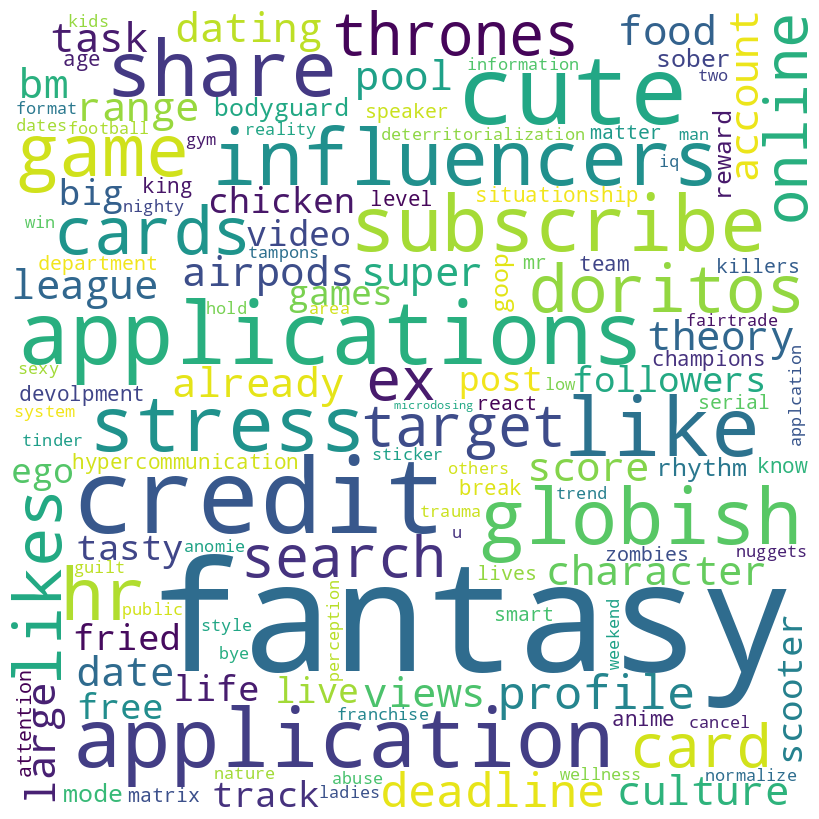

In [35]:
generate_non_arabic_wordcloud(df[df['creator'] == 'Fi Al Hadaraa'], column_name='episode_transcript', remove_stopwords=True)

**Analysis of Non-Arabic Words in Fil Hadaraa's Word Cloud**

**1. Digital Culture & Social Media**
- Many words in the cloud reflect **online behavior, social media, and digital trends**, such as:  
  - **subscribe, share, post, views, likes, influencers, profile, followers, online, account**.  
- These terms suggest discussions on **internet culture, digital identity, and social media influence**.

**2. Business & Finance**
- There are strong references to **financial topics** with words like:  
  - **credit, card, cards, target, deadline, reward, hr (human resources), task**.  
- This might indicate discussions on **credit systems, employment, deadlines, and productivity**.

**3. Gaming & Entertainment**
- A significant portion of words relate to **gaming, fantasy, and pop culture**, including:  
  - **fantasy, game, applications, character, league, throne, matrix, zombies**.  
- Mentions of **"Thrones" (possibly Game of Thrones)** and **"fantasy"** suggest topics on **movies, TV shows, and storytelling**.

**4. Food & Lifestyle**
- Several words focus on **food culture**, including:  
  - **food, chicken, doritos, tasty, fried, airpods (possibly linked to lifestyle trends)**.  
- This aligns with modern discussions on **consumerism and branding**.

**5. Work & Productivity**
- Words like **deadline, task, hr, application, development** suggest themes of **work, career, and productivity**.
- **Hypercommunication, situation-ship, microdosing** indicate discussions on **modern work culture and psychology**.

**6. Psychological & Social Themes**
- Words related to **mental health, emotions, and relationships** include:  
  - **stress, ex, ego, guilt, trauma, perception, judgmental, sober, situation-ship**.  
- These suggest **self-improvement, relationships, and social issues** are discussed.

#### Sentiment Analysis

In [36]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Read the extracted sentiment from the sentiment analysis notebook
df_sentiment = pd.read_csv("data/walid_sentiment_cleaned_data.csv")
df_sentiment.head()

episode_transcript                 creator  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  Al_Mokhbir_Al_Eqtisadi   
1  الراجل دا أنا عمري ما شفت حد زيه قبل كدا\nتحس ...  Al_Mokhbir_Al_Eqtisadi   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  Al_Mokhbir_Al_Eqtisadi   
3  في اواخر شهر سبتمبر سنه 2023 وزير\nالماليه الن...  Al_Mokhbir_Al_Eqtisadi   
4  في الساعات الاولى من صباح يوم 31 مايو\nسنه 201...  Al_Mokhbir_Al_Eqtisadi   

     length  tags  sentiment_score  
0  00:22:52   NaN         0.433861  
1  00:14:45   NaN         0.751848  
2  00:16:53   NaN         0.006446  
3  00:24:44   NaN         0.070738  
4  00:14:11   NaN         0.249777

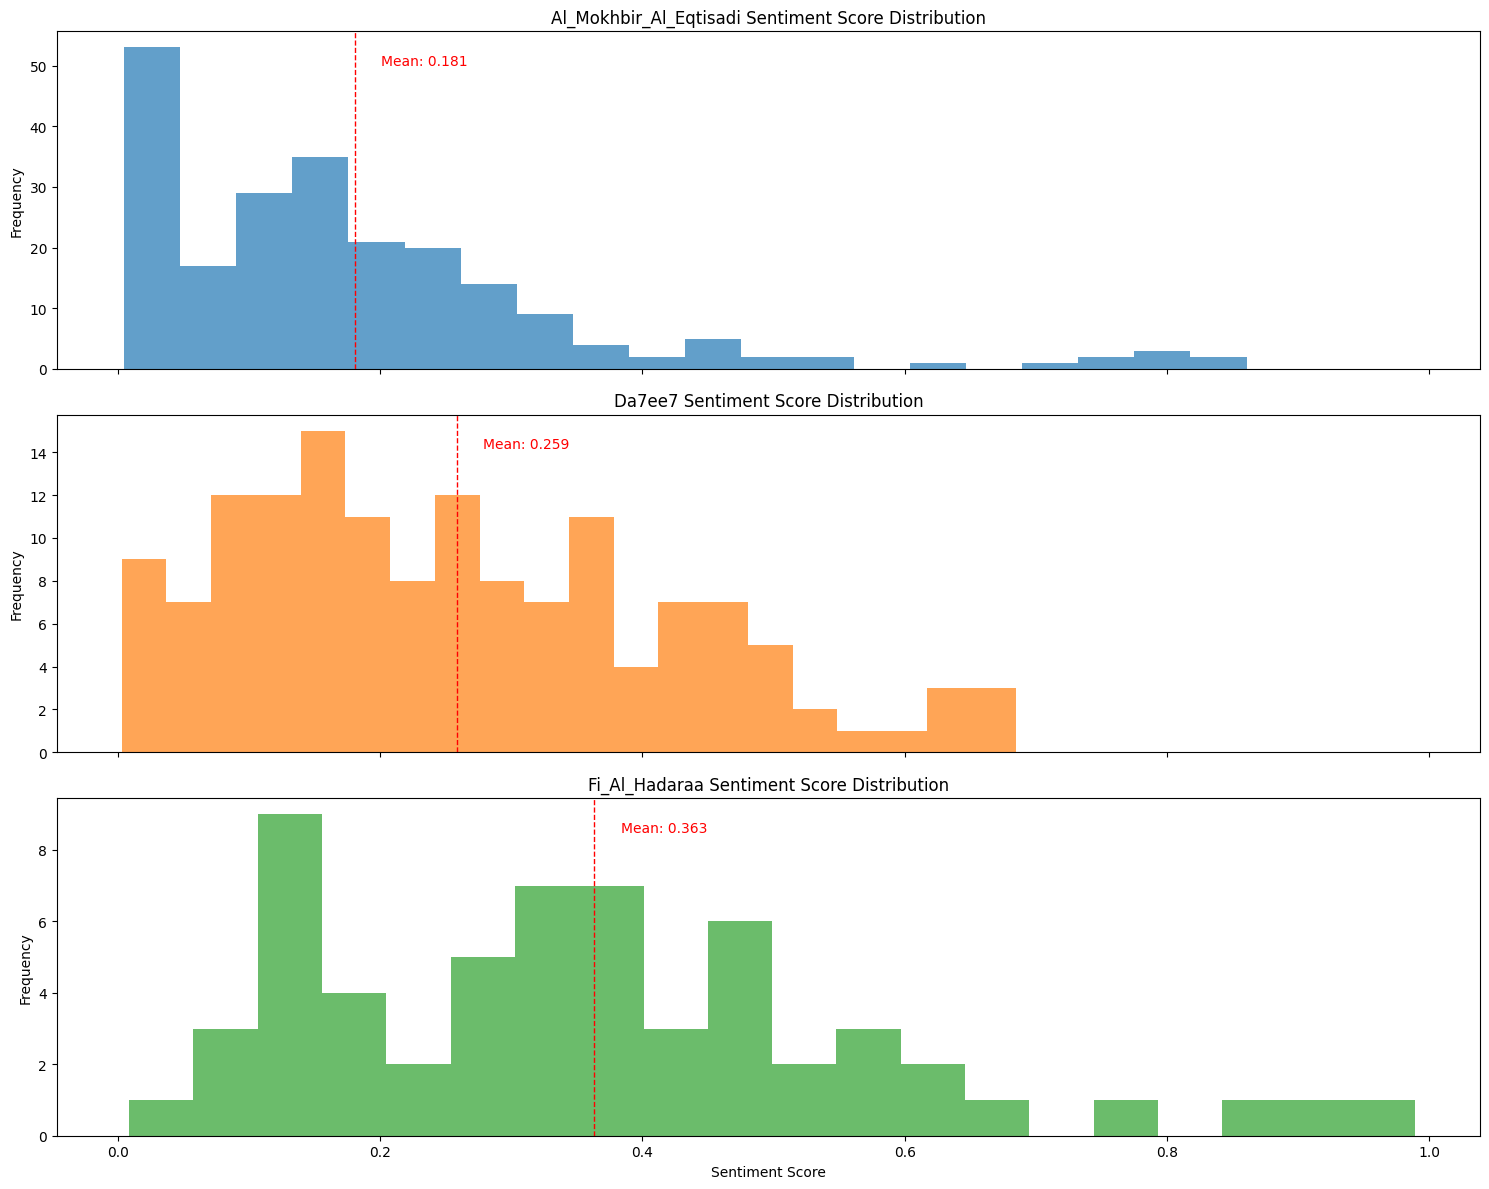

In [38]:
# Draw the sentiment score distribution by creator in 3 subplots sharing the same x-axis
fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=0.3)

for i, creator in enumerate(df_sentiment['creator'].unique()):
    creator_df = df_sentiment[df_sentiment['creator'] == creator]
    axes[i].hist(creator_df['sentiment_score'], bins=20, alpha=0.7, color=f'C{i}')
    axes[i].set_title(f"{creator} Sentiment Score Distribution")
    axes[i].set_ylabel("Frequency")
    
    # Add mean line
    mean_sentiment = creator_df['sentiment_score'].mean()
    axes[i].axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1)
    axes[i].text(mean_sentiment + 0.02, axes[i].get_ylim()[1]*0.9, f'Mean: {mean_sentiment:.3f}', color='red')

# Set the x-axis label only on the bottom subplot
axes[2].set_xlabel("Sentiment Score")

plt.tight_layout()
plt.show()

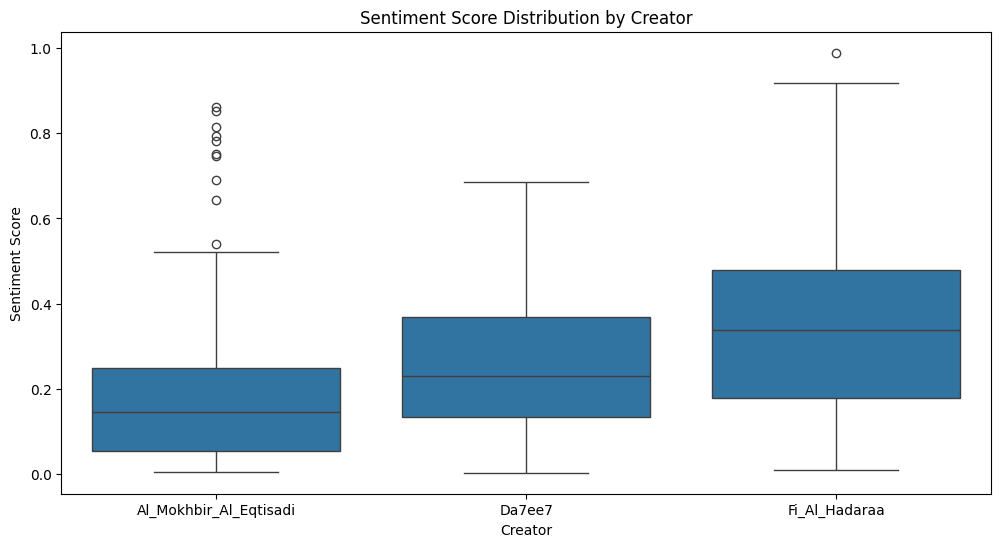

In [39]:
# Draw a boxplot of sentiment scores by creator
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_sentiment, x='creator', y='sentiment_score')
plt.title("Sentiment Score Distribution by Creator")
plt.ylabel("Sentiment Score")
plt.xlabel("Creator")
plt.show()

In [40]:
# View number of outliers by creator
def count_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (series < lower_bound).sum() + (series > upper_bound).sum()

outliers = df_sentiment.groupby('creator')['sentiment_score'].agg(count_outliers)
outliers

creator
Al_Mokhbir_Al_Eqtisadi    10
Da7ee7                     0
Fi_Al_Hadaraa              1
Name: sentiment_score, dtype: int64

Using the sentiment analysis model the following could be deduced from the above plots:
- `Al Mokhbir Al Eqtisadi` has the lowest sentiment in general compared to the other 2 creators.
- `Al Mokhbir Al Eqtisadi` has a `10` outliers compared to the other creators, which means occassionally he could make episodes talking about positive stuff.
- `Fi Al Hadaraa` has a higher overall sentiment compared to `Al Da7ee7` & `Al Mokhbir Al Eqtisadi`

#### Sarcasm Analysis

In [41]:
# imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display

In [42]:
sarcasm_df = pd.read_csv("data/sarcasm.csv")

In [43]:
sarcasm_df.head()

episode_transcript                 creator  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  Al_Mokhbir_Al_Eqtisadi   
1  الراجل دا أنا عمري ما شفت حد زيه قبل كدا\nتحس ...  Al_Mokhbir_Al_Eqtisadi   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  Al_Mokhbir_Al_Eqtisadi   
3  في اواخر شهر سبتمبر سنه 2023 وزير\nالماليه الن...  Al_Mokhbir_Al_Eqtisadi   
4  في الساعات الاولى من صباح يوم 31 مايو\nسنه 201...  Al_Mokhbir_Al_Eqtisadi   

     length  tags   sarcasm  
0  00:22:52   NaN  غير ساخر  
1  00:14:45   NaN  غير ساخر  
2  00:16:53   NaN      ساخر  
3  00:24:44   NaN      ساخر  
4  00:14:11   NaN  غير ساخر

In [44]:
# View the value counts of sarcasm
sarcasm_df['sarcasm'].value_counts()

sarcasm
ساخر        297
غير ساخر    129
Name: count, dtype: int64

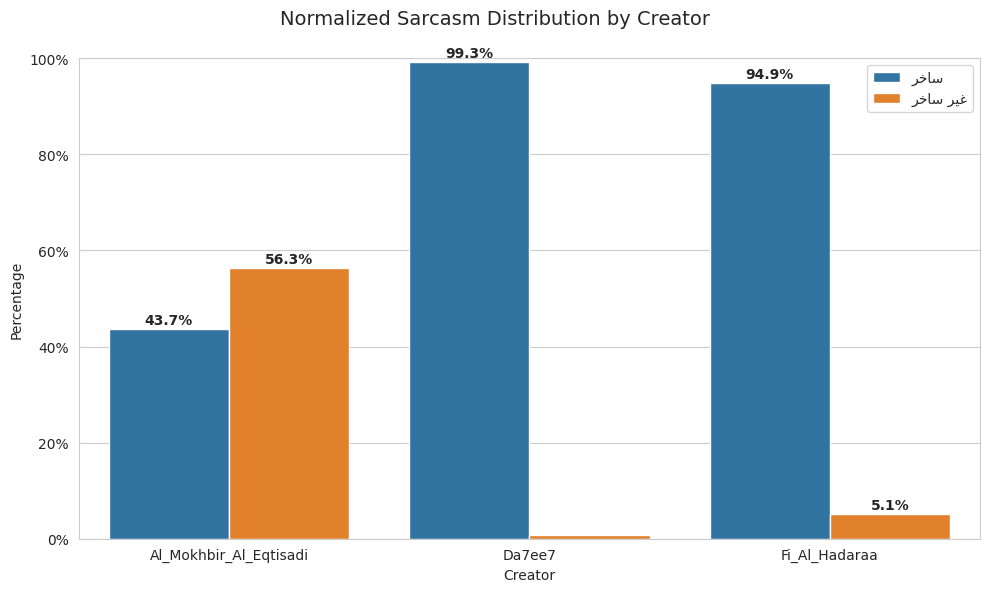

In [45]:
# Compare creators by sarcasm using normalized barplot
plt.figure(figsize=(10, 6))

# Create a contingency table
ct = pd.crosstab(sarcasm_df['creator'], sarcasm_df['sarcasm'], normalize='index').reset_index()
ct_melted = pd.melt(ct, id_vars=['creator'], var_name='sarcasm', value_name='percentage')

# Plot normalized values
sns.set_style("whitegrid")
ax = sns.barplot(data=ct_melted, x='creator', y='percentage', hue='sarcasm')
plt.suptitle("Normalized Sarcasm Distribution by Creator", fontsize=14)
plt.ylabel("Percentage")
plt.xlabel("Creator")
plt.ylim(0, 1)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    # Only add text if the height is greater than a small threshold
    if height > 0.01:  # Skip very small percentages
        ax.text(p.get_x() + p.get_width()/2., height + 0.01,
                f'{height:.1%}',
                ha="center", fontweight='bold')

# Handle Arabic text display
handles, labels = plt.gca().get_legend_handles_labels()
reshaped_labels = [arabic_reshaper.reshape(label) for label in labels]
bidi_labels = [get_display(label) for label in reshaped_labels]

plt.legend(handles, bidi_labels)
plt.tight_layout()
plt.show()

- **Sarcasm-Dominant Creators:**  
  - *Da7ee7* is **overwhelmingly sarcastic**, with **99.3%** of their content classified as sarcastic.  
  - *Fi_Al_Hadara* follows closely, with **94.9%** of their content being sarcastic.  
  - These creators strongly rely on **sarcasm and satire** as their main communication style.  

- **Balanced Creator:**  
  - *Al_Mokhbir_Al_Eqtisadi* has a more **even distribution**:  
    - **43.7% sarcastic** content.  
    - **56.3% non-sarcastic** content.  
  - This suggests a mix of **satirical and serious discussions**, catering to a broader audience.  

- **Interpretation of Content Style:**  
  - *Da7ee7* and *Fi_Al_Hadara* focus almost exclusively on **sarcasm-based storytelling or commentary**.  
  - *Al_Mokhbir_Al_Eqtisadi* appears to **balance humor with factual or serious reporting**.  


#### Apply NER to the transcripts to extract named entities and visualize the intersection between the entities extracted from the transcripts of the different channels using Venn diagrams
- Extract named entities from the transcripts using the `marefa-nlp/marefa-ner` model from the `huggingface` library
- Visualize the count of the entities extracted from the transcripts of the different channels using bar plots
- Visualize the intersection between the entities extracted from the transcripts of the different channels using Venn diagrams
- Visualize the intersection count using a venn diagram

Read NER from metadata

In [46]:
def read_ner_data(dir_path: str, df: pd.DataFrame) -> pd.DataFrame:
    """
    Load NER data from JSON files based on filenames in the DataFrame.

    :param dir_path: Path to the directory containing JSON files.
    :param df: DataFrame containing a 'file_name' column.
    :return: Updated DataFrame with NER data.
    """
    df["ner"] = None
    for i, row in df.iterrows():
        base_name = row["file_name"]
        json_path = os.path.join(dir_path, base_name + ".json")
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r', encoding="utf-8") as f:
                    ner_data = json.load(f).get("ner", None)
                    df.at[i, "ner"] = ner_data
            except json.JSONDecodeError:
                print(f"Warning: Failed to decode JSON in {json_path}")
                df.at[i, "ner"] = None
        else:
            df.at[i, "ner"] = None

    return df

In [47]:
mokhbir_df = read_ner_data(MOKHBIR_DIR + "/metadata_with_ner", mokhbir_df)
mokhbir_df.head()

file_name  \
0  المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل...   
1  المخبر_الاقتصادي__كيف_ترفع_الشركات_أسعار_المن...   
2  المخبر_الاقتصادي__لماذا_تبيع_الصين_كميات_كبيرة...   
3  المخبر_الاقتصادي__لماذا_سترتفع_أسعار_تذاكر_ال...   
4  المخبر_الاقتصادي__لماذا_تخفي_أمريكا_السلاح_ال...   

                                  episode_transcript    length  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  00:22:52   
1  في اواخر 2016 حصل هجوم كبير من\nالمستهلكين في ...  00:15:12   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  00:16:53   
3  في شهر مايو اللي فات\n23 شركة طيران\nأعلنوا إن...  00:14:23   
4  في صباح يوم 19 اكتوبر 2023 الرئيس\nالامريكي جو...  00:20:25   

                                                tags                 creator  \
0  [اسرائيل, اشرف ابراهيم, البرلمان البريطاني, ال...  Al Mokhbir Al Eqtisadi   
1  [أحجام المنتجات وأسعارها, أسعار المنتجات ترتفع...  Al Mokhbir Al Eqtisadi   
2  [أمريكا, أوروبا, اشرف ابراهيم, البنك المركزي ا...  Al Mokhbir Al Eqtisadi   
3  [Airlines, fly, tickets, أسعار التذاكر, الخطوط...  Al Mokhbir Al Eqtisadi   
4  [AJ+, AJ+ الدحيح, AJ+ عربي, AJ+ كبريت, AJ+ مع ...  Al Mokhbir Al Eqtisadi   

                                                 ner  
0  [{'token': 'عمان وقطر والبحرين والسعوديه', 'la...  
1  [{'token': '2016', 'label': 'time'}, {'token':...  
2  [{'token': 'نوفمبر', 'label': 'time'}, {'token...  
3  [{'token': 'شهر مايو', 'label': 'time'}, {'tok...  
4  [{'token': 'صباح يوم 19 اكتوبر 2023', 'label':...

In [48]:
hadaraa_df = read_ner_data(HADARAA_DIR + "/metadata_with_ner", hadaraa_df)
hadaraa_df.head()

file_name  \
0                                 الوحدة__في_الحضارة   
1                                الشجاعة__في_الحضارة   
2   لماذا_نحتاج_التعلم_بشكل_مستمر_للحفاظ_على_الوظيفة   
3                       فلسفة_نجيب_محفوظ__في_الحضارة   
4  ما_بين_الأمل_ولذة_التوقعات_.._أين_نجد_علاقات...   

                                  episode_transcript    length  \
0  كدا، خلاص!\nما حدش هيعتّبها تاني!\nإيه؟ الوحدة...  00:24:03   
1  والله ما أعرفه!\nإيه دا؟!\nإيه اللي بيحصل هنا ...  00:22:28   
2  دلوقتي المؤسسات والشركات بقت مخليها\nمساله تدر...  00:00:58   
3  اه يا حار تنسوا كل افضالي عليكم اخص\nعليكم\nاف...  00:22:47   
4  ها؟!\nقُلتي إيه يا أم "ميدو"؟\nأنا شايف إن الح...  00:15:03   

                                                tags        creator  \
0  [أنا العربي, ANA ALARABY, القصة كاملة, في العم...  Fi Al Hadaraa   
1  [الشجاعة, أنا العربي, انهيار الحضارة, في الحضا...  Fi Al Hadaraa   
2  [أنا العربي, ANA ALARABY, القصة كاملة, في العم...  Fi Al Hadaraa   
3  [أنا العربي, انهيار الحضارة, في الحضارة, Hadha...  Fi Al Hadaraa   
4  [أنا العربي, ANA ALARABY, القصة كاملة, في العم...  Fi Al Hadaraa   

                                                 ner  
0  [{'token': 'جوا برواز؟!', 'label': 'person'}, ...  
1  [{'token': 'أريَّحلي', 'label': 'person'}, {'t...  
2  [{'token': 'متعلم', 'label': 'job'}, {'token':...  
3  [{'token': 'النهارده', 'label': 'time'}, {'tok...  
4  [{'token': 'أبو "ميدو"', 'label': 'person'}, {...

In [49]:
da7ee7_df = read_ner_data(DA7EE7_DIR + "/metadata_with_ner", da7ee7_df)
da7ee7_df.head()

file_name  \
0  ماذا قال الدحيح عن مقاييس الجمال و الأتيكيت؟ ...   
1                                    النسيان  الدحيح   
2                                     الهاكر  الدحيح   
3                                    الخنزير  الدحيح   
4                              علاقات عن بعد  الدحيح   

                                  episode_transcript length  \
0  4.95: [موسيقى]\n59.42: [موسيقى]\n68.39: [موسيق...   None   
1  2.431: أنا خايف يا دكتور!\n4.554: ما يمكن أنسى...   None   
2  4.742: معلش يا حاج،\nالـ"ليفل سيكيوريتي" بتاعه...   None   
3  0.653: !أقسم بالله ما هسيبه غير إمّا يعتذر\n3....   None   
4  1.68: سلمى حبيبي لسه واصل حالا\n5.759: انا مش ...   None   

                                                tags creator  \
0  [الدحيح, eldahih, elda7ee7, da7ee7, al daheeh,...  Da7ee7   
1  [الدحيح, eldahih, elda7ee7, da7ee7, al daheeh,...  Da7ee7   
2  [الدحيح, eldahih, elda7ee7, da7ee7, al daheeh,...  Da7ee7   
3  [الدحيح, new media academy الدحيح, eldahih, el...  Da7ee7   
4  [الدحيح, برنامج الدحيح الجديد, حلقة الدحيح, بر...  Da7ee7   

                                                 ner  
0  [{'token': 'رمزي المرشدي', 'label': 'person'},...  
1  [{'token': '48.367:', 'label': 'time'}, {'toke...  
2  [{'token': 'عينوّر النافوخ.', 'label': 'person'}]  
3  [{'token': '3.36:', 'label': 'time'}, {'token'...  
4  [{'token': 'سلمى حبيبي', 'label': 'person'}, {...

In [50]:
def get_unique_ner_tokens_and_tags(df: pd.DataFrame) -> set:
    """
    Extract unique (token, label) pairs from a DataFrame where each row in the 'ner' 
    column contains a list of dictionaries with 'token' and 'label' keys.

    :param df: DataFrame containing an 'ner' column with lists of dicts.
    :return: Set of unique (token, label) pairs.
    """
    unique_tokens_tags = set()

    for ner_data in df['ner']:
        if isinstance(ner_data, list): 
            for entity in ner_data:
                if isinstance(entity, dict) and 'token' in entity and 'label' in entity and  entity['label'] != 'time':
                    unique_tokens_tags.add((entity['token'], entity['label']))

    return unique_tokens_tags

In [51]:
mokhbir_ner = get_unique_ner_tokens_and_tags(mokhbir_df)
hadaraa_ner = get_unique_ner_tokens_and_tags(hadaraa_df)
da7ee7_ner = get_unique_ner_tokens_and_tags(da7ee7_df)

print("Unique NER Tokens & Tags in Al Mokhbir Al Eqtisadi:")
print(mokhbir_ner)

print("\nUnique NER Tokens & Tags in Fi Al Hadaraa:")
print(hadaraa_ner)

print("\nUnique NER Tokens & Tags in Da7ee7:")
print(da7ee7_ner)

Unique NER Tokens & Tags in Al Mokhbir Al Eqtisadi:
{('الدول الافريقيه', 'location'), ('لورن كيلس', 'person'), ('الإرهابي', 'event'), ('آبل', 'product'), ('للفايد', 'person'), ('مارك', 'person'), ('تي اس ام سي', 'organization'), ('أمريكان', 'nationality'), ('نيوز نايت', 'artwork'), ('مستشار', 'job'), ('اوباما', 'person'), ('للاحتلال الاسرائيلي', 'event'), ('الاف بي اي', 'organization'), ('للسلاح الجوي الملكي الهولندي', 'organization'), ('الصناعه النرويجيه', 'organization'), ('اليابانيه', 'nationality'), ('أزمة الطاقة الفرنسية', 'event'), ('البرازيلي', 'nationality'), ('كارتر', 'person'), ('صندوق جي آي سي', 'organization'), ('تشافيز', 'person'), ('معهد سياسي سات الشعب اليهودي', 'organization'), ('وارن بافيت', 'person'), ('بنك اليابان', 'organization'), ('البحر الاحمر', 'location'), ('المانيا والنمسا والمجر وبلغاريا', 'location'), ('الحرب في أوكرانيا؟', 'event'), ('رئيسه الجامعه', 'job'), ('مطار وارتامبو الدولي', 'location'), ('بلومبرغ وواشنطن بوست', 'organization'), ('اليابانية', 'natio

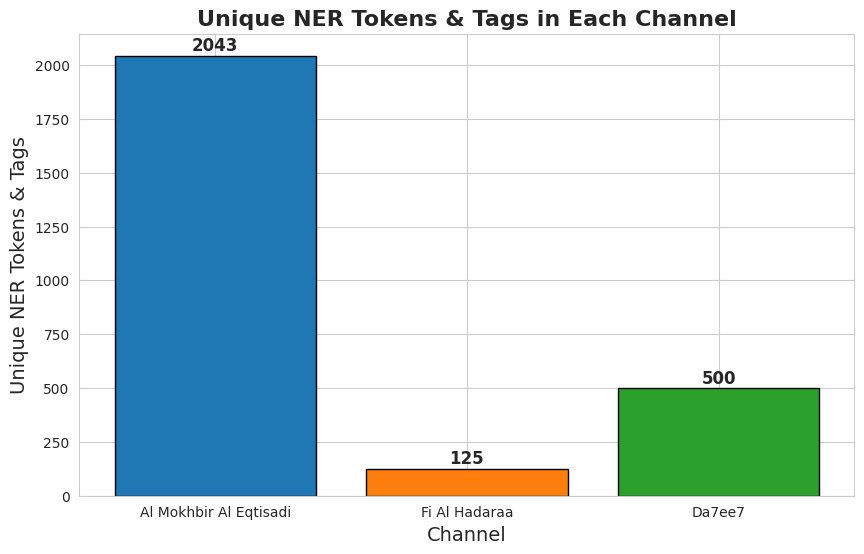

In [52]:
ner_counts = {
    'Al Mokhbir Al Eqtisadi': len(mokhbir_ner),
    'Fi Al Hadaraa': len(hadaraa_ner),
    'Da7ee7': len(da7ee7_ner)
}

colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

plt.figure(figsize=(10, 6))
bars = plt.bar(ner_counts.keys(), ner_counts.values(), color=colors, edgecolor='black')

for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() + 5, 
        str(bar.get_height()), 
        ha='center', va='bottom', fontsize=12, fontweight='bold'
    )

plt.xlabel('Channel', fontsize=14)
plt.ylabel('Unique NER Tokens & Tags', fontsize=14)
plt.title('Unique NER Tokens & Tags in Each Channel', fontsize=16, fontweight='bold')

plt.show()

In [53]:
def get_ner_intersection(*ner_lists):
    """
    Compute the intersection of unique NER tokens and tags across multiple datasets.

    :param ner_lists: Multiple lists of NER entries, where each entry is a list of dictionaries
                      containing 'token' and 'label' keys.
    :return: A set containing the common (token, label) pairs across all datasets.
    """
    ner_sets = []
    
    for ner_list in ner_lists:
        ner_set = set()
        for ner_entry in ner_list:
            if isinstance(ner_entry, list):  # Ensure each row contains a list of dicts
                for entry in ner_entry:
                    if isinstance(entry, dict) and 'token' in entry and 'label' in entry:
                        ner_set.add((entry['token'], entry['label']))
        ner_sets.append(ner_set)

    if not ner_sets:
        return set()

    return set.intersection(*ner_sets)

In [54]:
common_ner = get_ner_intersection(mokhbir_ner, hadaraa_ner, da7ee7_ner)
print(common_ner)

set()


After extracting the named entities from the transcripts, we wanted to compare the entities extracted from the different channels to see if there are any common entities between them. However, we found that there is no intersection between the entities extracted from the different channels. 

This could be due to the fact that the entities extracted from the transcripts are not accurate, since by looking at the entities extracted from the metadata, we found that:
- Some entities are not named entities
- Some entities are not named correctly since we are using a pre-trained model that might not be trained on the same domain as the transcripts
- There is an intersection between the channels but entities are of different wording (e.g. "السعودية" and "المملكة العربية السعودية")


So Although we can show no intersection directly, By examining the entities visually, we can't be sure that there is no intersection between the entities extracted from the different channels.

#### Clustering sample of episodes based on TF-IDF vectors of the transcript to find if the data is usable for clustering or not
- Visualize the episodes using UMAP (2D and 3D)
- Use KMeans to cluster the data 
- Visualize the clusters

Convert transcripts to TF-IDF vectors

In [55]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
arabic_stopwords = set(stopwords.words('arabic'))

# Combine Transcripts & Assign Labels
mokhbir_transcripts = mokhbir_df['episode_transcript'].tolist()
hadaraa_transcripts = hadaraa_df['episode_transcript'].tolist()
da7ee7_transcripts = da7ee7_df['episode_transcript'].tolist()

all_transcripts = mokhbir_transcripts + hadaraa_transcripts + da7ee7_transcripts

# Create labels for each channel
labels = (['Mokhbir'] * len(mokhbir_transcripts) +
          ['Hadaraa'] * len(hadaraa_transcripts) +
          ['Da7ee7'] * len(da7ee7_transcripts))

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words=list(arabic_stopwords))
X_tfidf = vectorizer.fit_transform(all_transcripts)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/karimgamaleldin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/karimgamaleldin/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['آمين', 'أب', 'أخ', 'أفعل', 'أفعله', 'ؤلاء', 'إل', 'إم', 'ات', 'اتان', 'ارتد', 'ان', 'انفك', 'برح', 'تان', 'تبد', 'تحو', 'تعل', 'حد', 'حم', 'حي', 'خب', 'ذار', 'سيما', 'صه', 'ظل', 'ظن', 'عد', 'قط', 'مر', 'مكان', 'مكانكن', 'نب', 'هات', 'هب', 'واها', 'وراء'] not in stop_words.
  warnings.warn(


Visualize the data in 2D and 3D using UMAP

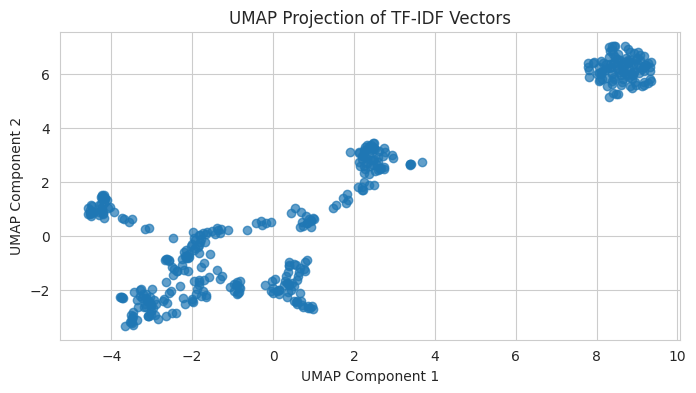

In [56]:
import umap

# Apply UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_tfidf.toarray())

# Visualize the transcripts in 2D
plt.figure(figsize=(8,4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.7)
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP Projection of TF-IDF Vectors")
plt.show()

Assign a color to each channel to show if clusters are channel-specific or not

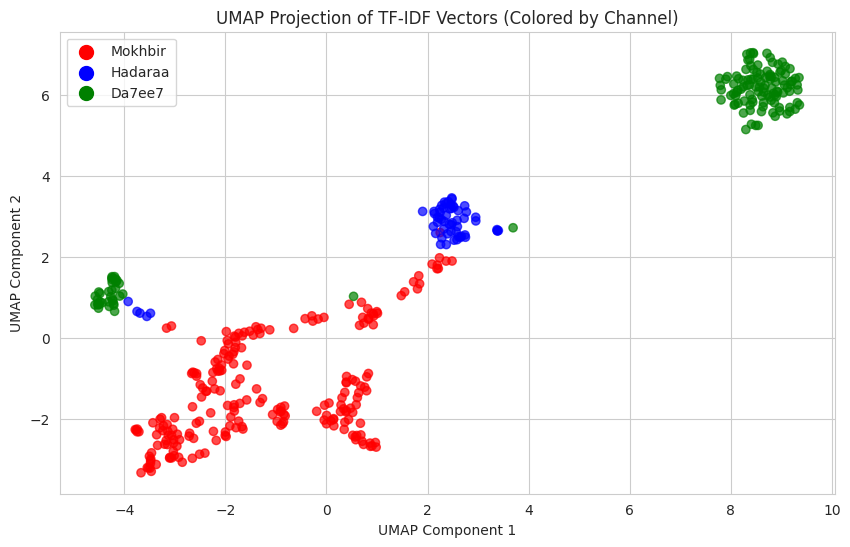

In [57]:
# Assign Colors to Each Channel
channel_colors = {
    'Mokhbir': 'red',
    'Hadaraa': 'blue',
    'Da7ee7': 'green'
}

colors = np.array([channel_colors[label] for label in labels])

# Visualize the transcripts in 2D with colors
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, alpha=0.7)

plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("UMAP Projection of TF-IDF Vectors (Colored by Channel)")

for channel, color in channel_colors.items():
    plt.scatter([], [], color=color, label=channel, s=100)  # Dummy points for legend

plt.legend()
plt.show()

Visualize the transcripts in 3D using UMAP

In [58]:
# Reduce dimensions using UMAP to 3D
umap_model = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_model.fit_transform(X_tfidf.toarray())

/home/karimgamaleldin/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [59]:
import plotly.graph_objects as go

def plot_3d_vectors(X_umap, labels=None, colors=None, title="3D Vector Representation"):
    """
    Plots a 3D vector representation of data points projected via UMAP.

    Parameters:
        X_umap (ndarray): 2D array of shape (n_samples, 3) containing 3D coordinates.
        labels (list, optional): List of labels corresponding to each data point.
        colors (list, optional): List of colors for each data point. If None, defaults to Plotly's automatic coloring.
        title (str, optional): Title of the plot.

    Returns:
        None: Displays the interactive 3D plot.
    """
    fig = go.Figure()

    # Determine axis scale
    axis_length = np.max(np.abs(X_umap)) * 1.2 

    # Add axis lines (for reference)
    fig.add_trace(go.Scatter3d(x=[-axis_length, axis_length], y=[0, 0], z=[0, 0], mode='lines',
                               line=dict(color='black', width=3), name="X-axis")) 
    fig.add_trace(go.Scatter3d(x=[0, 0], y=[-axis_length, axis_length], z=[0, 0], mode='lines',
                               line=dict(color='black', width=3), name="Y-axis"))  
    fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[-axis_length, axis_length], mode='lines',
                               line=dict(color='black', width=3), name="Z-axis")) 

    # Plot vectors as rays
    for i in range(len(X_umap)):
        label = f"{labels[i]} {i+1}" if labels is not None else f"Vector {i+1}"
        
        fig.add_trace(go.Scatter3d(
            x=[0, X_umap[i, 0]],
            y=[0, X_umap[i, 1]],
            z=[0, X_umap[i, 2]],
            mode='lines+markers',
            marker=dict(size=5, color=colors[i] if colors is not None else None), 
            line=dict(width=3, color=colors[i] if colors is not None else None),
            name=label
        ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title="UMAP Dim 1", backgroundcolor="rgb(240, 240, 240)"),
            yaxis=dict(title="UMAP Dim 2", backgroundcolor="rgb(240, 240, 240)"),
            zaxis=dict(title="UMAP Dim 3", backgroundcolor="rgb(240, 240, 240)"),
        ),
        width=900,
        height=700,
        showlegend=True
    )

    fig.show()

In [60]:
plot_3d_vectors(X_umap, labels=labels, colors=None, title="3D UMAP Projection of TF-IDF Vectors")

In [61]:
plot_3d_vectors(X_umap, labels=labels, colors=colors, title="3D UMAP Projection of TF-IDF Vectors (Colored by Channel)")

Apply KMeans clustering to the data

In [62]:
from sklearn.cluster import KMeans
# Apply K-Means Clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10)
kmeans_labels = kmeans.fit_predict(X_umap)

cluster_colors = ['red', 'blue', 'green', 'purple']
colors = [cluster_colors[label] for label in kmeans_labels]

In [63]:
plot_3d_vectors(X_umap, labels=labels, colors=colors, title="3D UMAP Projection of TF-IDF Vectors (Clustered by K-Means)")

#### Arabic Words Analysis

In [64]:
# Cleaning function
from scripts.all_stopwords import all_stopwords

 
arabic_stopwords = list(all_stopwords)
def clean_arabic_txt(text: str) -> str:
    """
    Cleans Arabic text by removing timestamps, special tags, numbers, punctuation,
    ellipses, quotations, and unnecessary diacritics while preserving words.
    """
    # Remove timestamps (e.g., 5.127: or 11.167:)
    text = re.sub(r'^\d+\.\d+:\s*', '', text)  

    # Remove special tags like [موسيقى], [ضحك], etc.
    text = re.sub(r'\[.*?\]', '', text)  

    # Remove numbers
    text = re.sub(r'\d+', '', text)     

    # Remove ellipses (...)
    text = re.sub(r'\.{2,}', '', text)  

    # Separate punctuation & quotations from words by adding spaces around them
    text = re.sub(r'([^\w\s])', r' \1 ', text)  

    # Remove all punctuation, including quotations
    text = re.sub(r'[^\w\s]', '', text)  

    # # Remove english characters
    text = re.sub(r'[a-zA-Z]', '', text)

    # Remove Tashkeel (diacritics) and Tatweel (elongation)
    text = araby.strip_tashkeel(text)  
    text = araby.strip_tatweel(text)  

    # Trim and remove stopwords
    text = text.strip()
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])

    return text

# Apply the cleaning function to the episode transcripts
df['cleaned_transcript'] = df['episode_transcript'].apply(clean_arabic_txt)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/karimgamaleldin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


file_name  \
0  المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل...   
1  المخبر_الاقتصادي__كيف_ترفع_الشركات_أسعار_المن...   
2  المخبر_الاقتصادي__لماذا_تبيع_الصين_كميات_كبيرة...   
3  المخبر_الاقتصادي__لماذا_سترتفع_أسعار_تذاكر_ال...   
4  المخبر_الاقتصادي__لماذا_تخفي_أمريكا_السلاح_ال...   

                                  episode_transcript  length  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  1372.0   
1  في اواخر 2016 حصل هجوم كبير من\nالمستهلكين في ...   912.0   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  1013.0   
3  في شهر مايو اللي فات\n23 شركة طيران\nأعلنوا إن...   863.0   
4  في صباح يوم 19 اكتوبر 2023 الرئيس\nالامريكي جو...  1225.0   

                                                tags                 creator  \
0  [اسرائيل, اشرف ابراهيم, البرلمان البريطاني, ال...  Al Mokhbir Al Eqtisadi   
1  [أحجام المنتجات وأسعارها, أسعار المنتجات ترتفع...  Al Mokhbir Al Eqtisadi   
2  [أمريكا, أوروبا, اشرف ابراهيم, البنك المركزي ا...  Al Mokhbir Al Eqtisadi   
3  [Airlines, fly, tickets, أسعار التذاكر, الخطوط...  Al Mokhbir Al Eqtisadi   
4  [AJ+, AJ+ الدحيح, AJ+ عربي, AJ+ كبريت, AJ+ مع ...  Al Mokhbir Al Eqtisadi   

   transcript_length  non_arabic_words  \
0               3285                 0   
1               2231                 1   
2               2328                 0   
3               2119                26   
4               2783                 0   

                                  cleaned_transcript  
0  عمان وقطر والبحرين والسعوديه الدول العربيه الا...  
1  اواخر هجوم كبير المستهلكين بريطانيا شركه موندل...  
2  وزراء ماليه مجموعه الدول العشر الكبرى الجي اجت...  
3  فات شركة طيران أعلنوا إنهم حيبطلوا شغلانة الطي...  
4  اكتوبر الرئيس الامريكي جو بايدن العاصمه الامري...

In [65]:
df.to_csv("data/cleaned_transcripts.csv", index=False)

In [66]:
from wordcloud import WordCloud
def column_to_wordcloud(df: pd.DataFrame, column: str, font_file: str): 
    """
    Parameters:
      df: the dataframe that contains the column 
      column: the name of the column that contains the text 
      font_file: the path to the font file for Arabic characters 
      stopwords: a list of words to exclude from the wordcloud

    Outputs:
        None. The function only displays the word cloud image.
    """
    text = " ".join(t for t in df[column].dropna())
    reshaped_text = arabic_reshaper.reshape(text)
    display_text = get_display(reshaped_text)  

    wordcloud = WordCloud(font_path=font_file, width=800, height=400, random_state=1,
                          background_color='white', collocations=False).generate(display_text)

    plt.figure(figsize=(10, 10), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [67]:
mokhber_df = df[df['creator'] == 'Al Mokhbir Al Eqtisadi']
da7ee7_df = df[df['creator'] == 'Da7ee7']
hadara_df = df[df['creator'] == 'Fi Al Hadaraa']

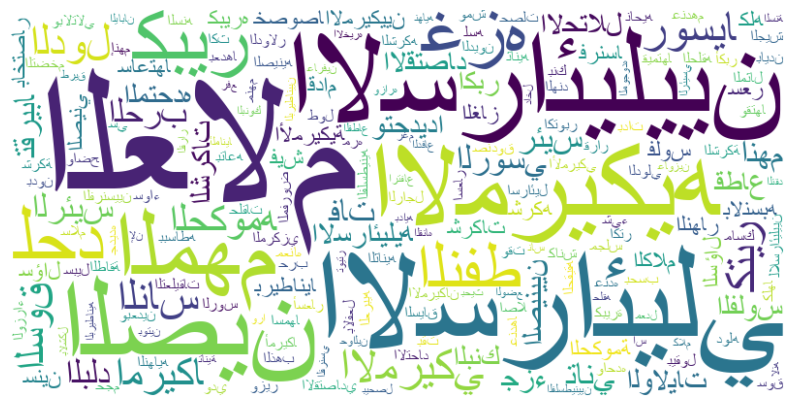

In [68]:
font_file = './arial.ttf'
column_to_wordcloud(mokhber_df, 'cleaned_transcript', font_file= font_file)

Insights gained:

- Dominant Topics: Words like "الإسرائيلي" , "الصين" , "النفط" , "العالم" , "الأمريكي" suggest a strong focus on geopolitics, global economy, and energy markets.
- Economic Emphasis: Terms like "السوق" , "الغاز" , "النفط" , "الدول" indicate discussions related to trade, commodities, and international financial dynamics.
- Political Context: The presence of "الروسي" , "أمريكي" , "احتلال"  suggests coverage of political conflicts and international relations.
- Repetition of "الإسرائيلي" & "الإسرائيليين": This might indicate that a significant portion of the content is related to Israeli affairs, possibly in the context of political, economic, or strategic discussions.

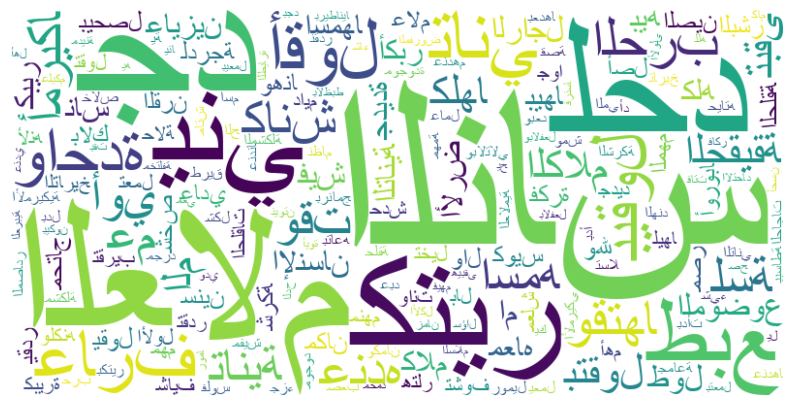

In [69]:
font_file = './arial.ttf'
column_to_wordcloud(da7ee7_df, 'cleaned_transcript', font_file= font_file)

Insights gained:

- General and Philosophical Tone: Words like "الناس" , "العالم" , "كبير" , "أكثر" , "الحياة"  suggest a broad, thought-provoking narrative, characteristic of Da7ee7’s educational and storytelling approach.
- Curiosity-Driven Discussions: The presence of "الحلقة" , "الموضوع" , "الكلام" indicates a focus on explaining various subjects in an engaging manner.
- Diverse Topics: Unlike Al Mokhbir Al Eqtisadi, this word cloud does not emphasize geopolitics or economics but instead features words related to science, philosophy, and social themes.
- Conversational Style: The frequent use of words like "بتقول" , "بيحصل" , "تفكر"  aligns with Da7ee7’s storytelling and explanatory format, which engages the audience in a casual yet informative manner.

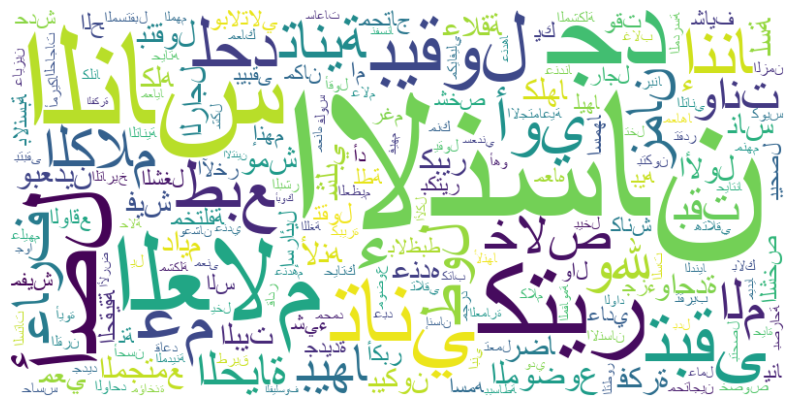

In [70]:
font_file = './arial.ttf'
column_to_wordcloud(hadara_df, 'cleaned_transcript', font_file= font_file)

Insights gained:
- Human-Centric Themes: The most prominent words include "الإنسان" , "الناس" , "الحياة" , indicating a strong focus on societal development
- Unlike `Al Mokhbir Al Eqtisadi`, which focuses on economics and geopolitics, `Fi Al Hadara` leans toward human civilization, history, and philosophical discussions.

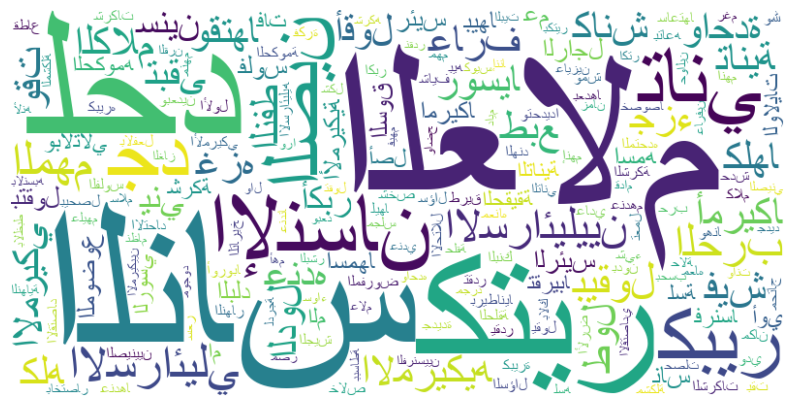

In [71]:
font_file = './arial.ttf'
column_to_wordcloud(df, 'cleaned_transcript', font_file= font_file)

Insights gained:

- The combined dataset captures a broader spectrum of topics than individual channels.
- The mix of economic, historical, and philosophical keywords suggests a well-balanced dataset that covers both factual and analytical discussions.
- Potential Application: This dataset could be useful for multi-label classification, as different transcripts might intersect across multiple themes (e.g., economy + history, philosophy + geopolitics)
- Key Recurring Themes Across Channels:
    - Humanity & Society: Dominant words like "الناس" , "الإنسان", "الحياة"  highlight a strong focus on societal topics.
    - Global and Geopolitical Discussions: The presence of "العالم" , "الدول" , "الصين" , "الروسي" , "الإسرائيلي" , "الأمريكي" (American) suggests coverage of international relations and economic affairs

#### Phrase Cloud

In [72]:
def generate_phrase_cloud(
        df: pd.DataFrame, 
        column_name: str, 
        ngram: int=2, 
        background_color: str='white', 
        max_words: int=200, 
        font_path: str='./arial.ttf'):
    """
    Generates a phrase cloud from a specified column in a DataFrame, supporting Arabic text.
    Only n-gram phrases are displayed, avoiding single words.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the text data.
    - column_name (str): The name of the column containing the text.
    - ngram (int): The n-gram size (e.g., 2 for bigrams, 3 for trigrams).
    - background_color (str): Background color for the word cloud.
    - max_words (int): Maximum number of words to display in the cloud.
    - font_path (str): Path to an Arabic font (.ttf) file.
    
    Returns:
    - Displays the generated phrase cloud.
    """

    def clean_and_tokenize(text):
        text = text.lower()  
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        tokens = text.split()  
        return tokens

    df['tokens'] = df[column_name].dropna().astype(str).apply(clean_and_tokenize)
    tokens_list = df['tokens'].tolist()
    
    def generate_ngrams(tokens, n):
        ngrams = zip(*[tokens[i:] for i in range(n)])
        return ['_'.join(ngram) for ngram in ngrams]
    
    all_ngrams = []
    for tokens in tokens_list:
        ngrams = generate_ngrams(tokens, ngram)
        all_ngrams.extend(ngrams)
    
    phrase_text = " ".join(all_ngrams)
    
    reshaped_text = arabic_reshaper.reshape(phrase_text)
    display_text = get_display(reshaped_text)  
    
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color=background_color, 
                          max_words=max_words, 
                          font_path=font_path  
                          ).generate(display_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


/tmp/ipykernel_62774/4262269167.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



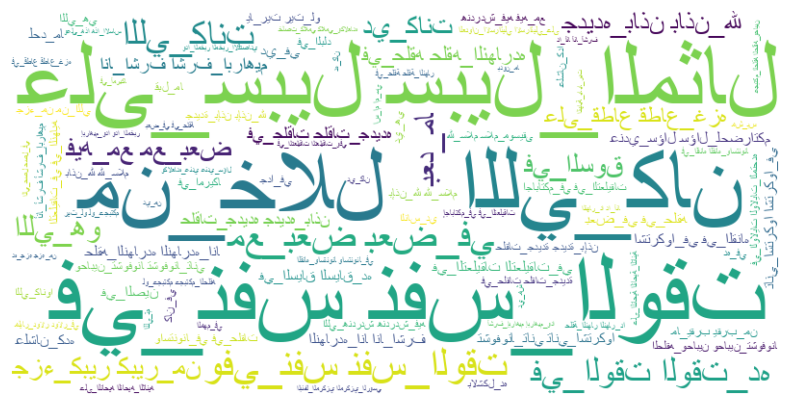

In [73]:
generate_phrase_cloud(mokhber_df, 'episode_transcript', ngram=2, background_color='white', max_words=100)

Insights gained from the phrase cloud generated from bigrams:
- Common phrases like "في نفس الوقت" , "على سبيل المثال" , "من خلال"  suggest that the content of ten involves comparisons, contextual explanations, and structured argumentation.
- This aligns with the channel's analytical and explanatory nature, which aims to break down economic and political events.
- Phrases like "في السوق" , "على قطاع غزة" indicate that discussions revolve around market trends and geopolitical issues.

/tmp/ipykernel_62774/4262269167.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



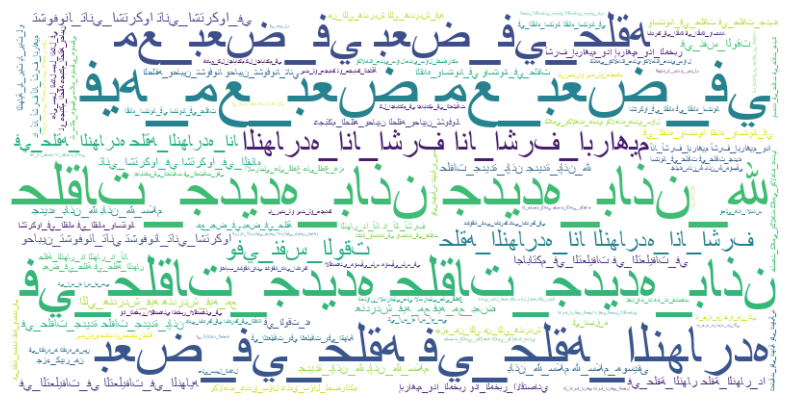

In [74]:
generate_phrase_cloud(mokhber_df, 'episode_transcript', ngram=3, background_color='white', max_words=100)

Insights gained:
- Phrases like "حلقات جديدة باذن " (new episodes, God willing), "في حلقه في" (in an episode in), "في حلقة النهاردة" (today’s episode) suggest that the most prominant phrases are the promotional or introductory ones.

/tmp/ipykernel_62774/4262269167.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



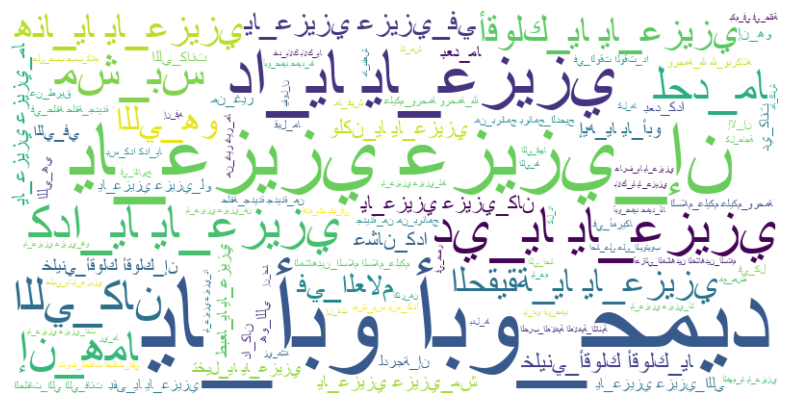

In [75]:
generate_phrase_cloud(da7ee7_df, 'episode_transcript', ngram=2, background_color='white', max_words=100)

Insights gained:
- The most prominent phrase "يا عزيزي"  is a signature phrase of El Da7ee7, reinforcing his casual, friendly, and engaging storytelling approach.
- The repetition of "يا عزيزي كدا"  and "يا عزيزي إن" indicates a strong use of rhetorical style and audience engagement
- frequent use of nicknames used like "يا أبو حميد"

/tmp/ipykernel_62774/4262269167.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



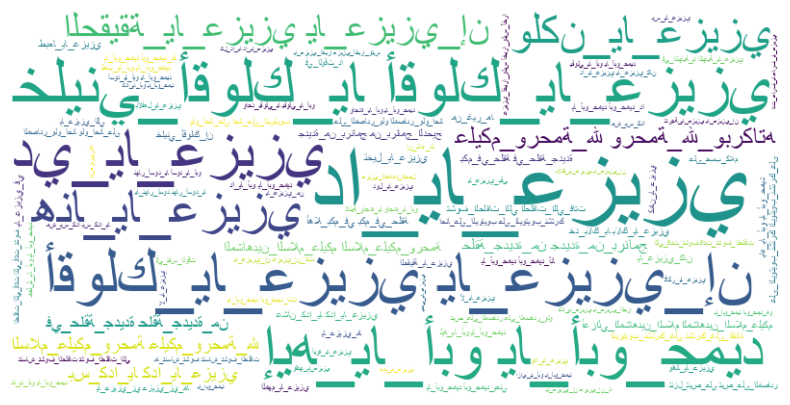

In [76]:
generate_phrase_cloud(da7ee7_df, 'episode_transcript', ngram=3, background_color='white', max_words=100)

Insights gained:
- Same thing as the phrase cloud of ngrams=2 in which el Da7ee7 uses his signature phrases and catchphrases which is " أقولك يا عزيزي"

/tmp/ipykernel_62774/4262269167.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



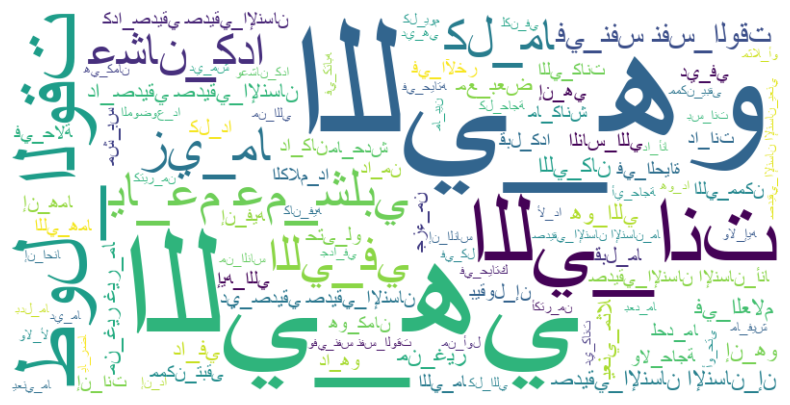

In [77]:
generate_phrase_cloud(hadara_df, 'episode_transcript', ngram=2, background_color='white', max_words=100)

Insights gained:
- The phrase "يا عم شلبي" introduces an informal, engaging, and possibly humorous aspect, making the content more relatable and digestible for the audience
- Frequent use of pronouns, temporal markers and stopwords.

/tmp/ipykernel_62774/4262269167.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



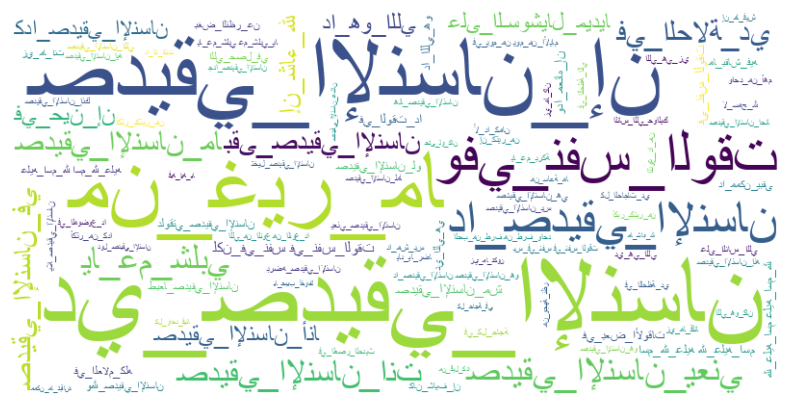

In [78]:
generate_phrase_cloud(hadara_df, 'episode_transcript', ngram=3, background_color='white', max_words=100)

Insights gained:
- Fi Al Hadara uses a direct and engaging storytelling style, frequently addressing the audience as "صديقي الانسان" to create a personal and reflective atmosphere
- Lots of regularly-used phrases like "ان شاء الله", "في الحالة دي

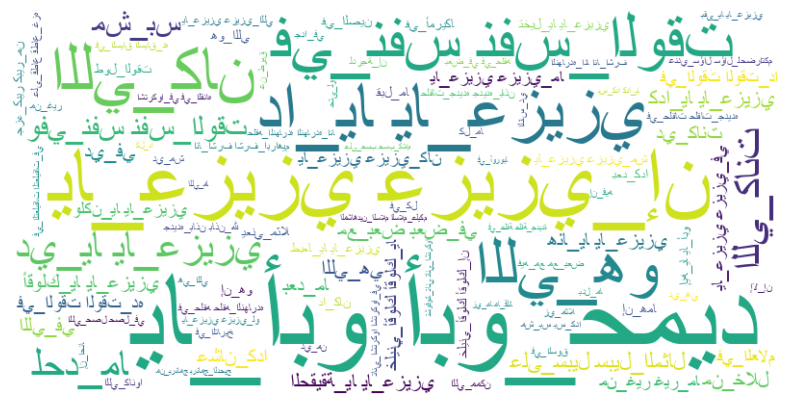

In [79]:
generate_phrase_cloud(df, 'episode_transcript', ngram=2, background_color='white', max_words=100)

Insights gained:
- Dominance of Conversational and Catchphrase Elements "يا عزيزي", "أبو حميد" coming from Da7ee7 channel and "نفس الوقت" coming from Fi el hadaraa and Al Mokhbir Al Eqtisadi suggests informal, friendly interactions.


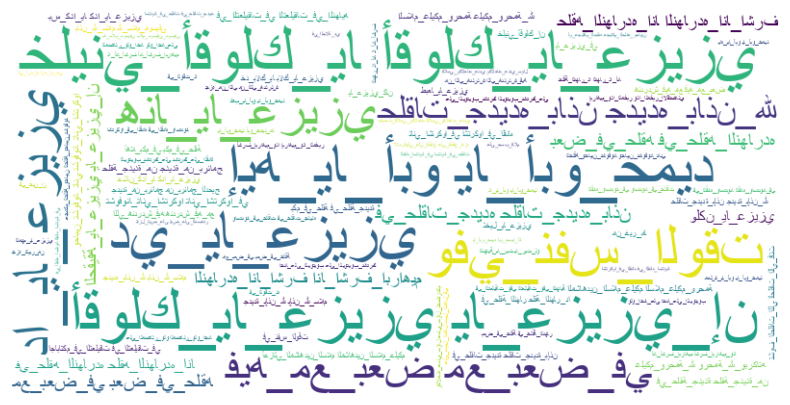

In [80]:
generate_phrase_cloud(df, 'episode_transcript', ngram=3, background_color='white', max_words=100)

The phrases mainly consist of introductory and catchy expressions from all channels, often used to engage the audience and set the context rather than convey deep content: 
- Strong Influence of Da7ee7’s Conversational Style like "أقولك يا عزيزي" , "دي يا عزيزي", "هنا يا عزيزي"  highlight Da7ee7’s rhetorical and engaging storytelling.
- Phrases from Al Mokhbir Al Eqtisadi like "في نفس الوقت" , " في حلقة النهاردة" 


#### Bar Charts

The following barcharts indicate the most used phrases (bigrams, trigrams) fro each creator and along all creators at the same time

In [81]:
def generate_top_k_ngrams(
        df: pd.DataFrame, 
        column_name: str, 
        ngram: int=2, 
        k: int=10):
    """
    Generates the most repeated n-grams from a specified column in a DataFrame
    and displays the top k phrases as a bar chart. Supports Arabic text.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the text data.
    - column_name (str): The name of the column containing the text.
    - ngram (int): The n-gram size (e.g., 2 for bigrams, 3 for trigrams).
    - k (int): The number of top phrases to display.
    
    Returns:
    - Displays a bar chart of the most repeated k phrases.
    """

    def clean_and_tokenize(text):
        text = text.lower()  
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
        tokens = text.split()  
        return tokens

    df['tokens'] = df[column_name].dropna().astype(str).apply(clean_and_tokenize)
    tokens_list = df['tokens'].tolist()
    
    def generate_ngrams(tokens, n):
        ngrams = zip(*[tokens[i:] for i in range(n)])
        return [' '.join(ngram) for ngram in ngrams]
    
    all_ngrams = []
    for tokens in tokens_list:
        ngrams = generate_ngrams(tokens, ngram)
        all_ngrams.extend(ngrams)
    
    ngram_counter = Counter(all_ngrams)
    most_common_ngrams = ngram_counter.most_common(k)
    
    phrases, counts = zip(*most_common_ngrams)
    
    reshaped_phrases = [get_display(arabic_reshaper.reshape(phrase)) for phrase in phrases]
    
    plt.figure(figsize=(12, 6))
    plt.barh(reshaped_phrases, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top {k} Most Repeated {ngram}-grams')
    plt.gca().invert_yaxis()  
    plt.show()


/tmp/ipykernel_62774/3194910396.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



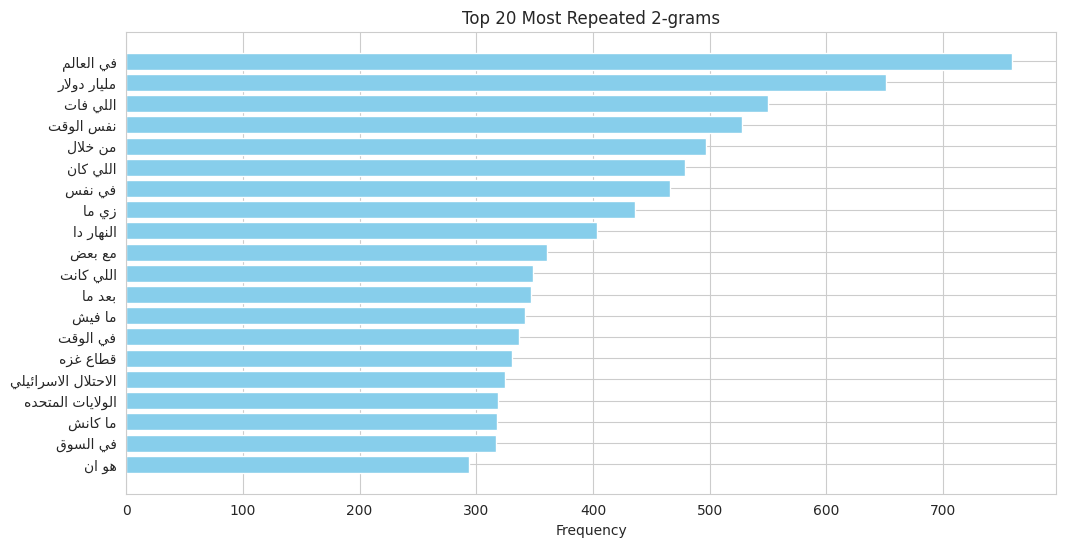

In [82]:
generate_top_k_ngrams(mokhber_df, column_name='episode_transcript', ngram=2, k=20)

/tmp/ipykernel_62774/3194910396.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/karimgamaleldin/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 65010 (\N{ARABIC LIGATURE ALLAH ISOLATED FORM}) missing from font(s) DejaVu Sans.



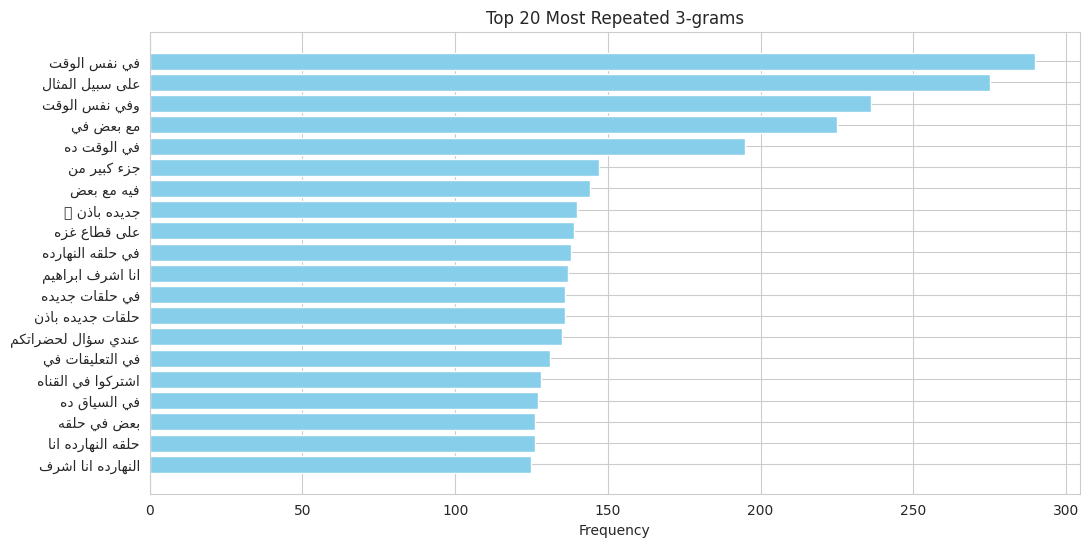

In [83]:
generate_top_k_ngrams(mokhber_df, column_name='episode_transcript', ngram=3, k=20)

/tmp/ipykernel_62774/3194910396.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



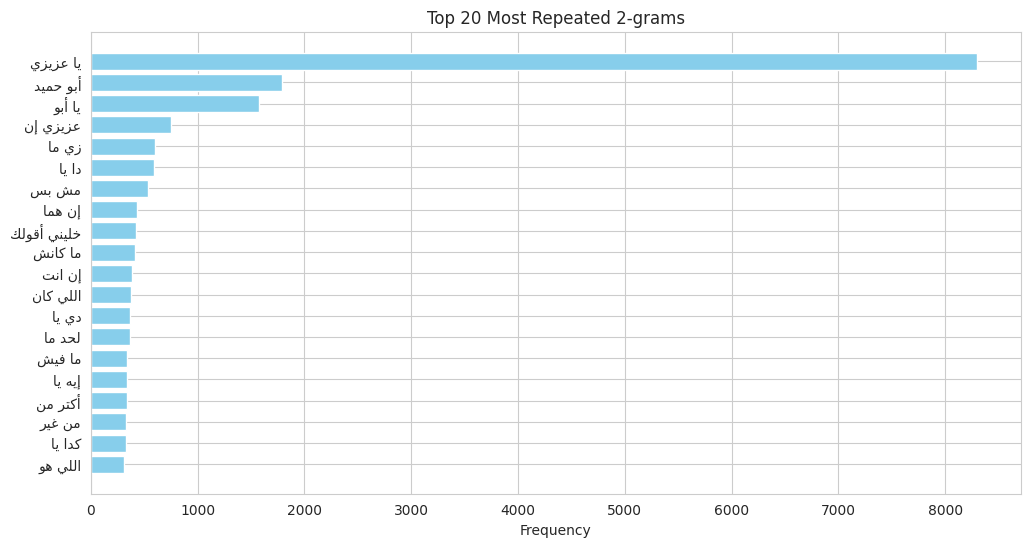

In [84]:
generate_top_k_ngrams(da7ee7_df, column_name='episode_transcript', ngram=2, k=20)

/tmp/ipykernel_62774/3194910396.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



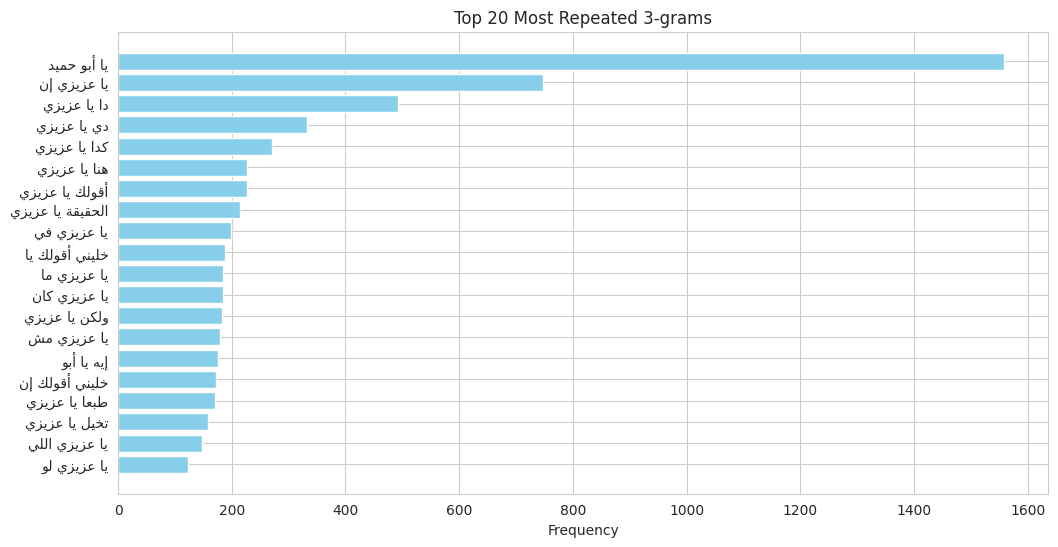

In [85]:
generate_top_k_ngrams(da7ee7_df, column_name='episode_transcript', ngram=3, k=20)

/tmp/ipykernel_62774/3194910396.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



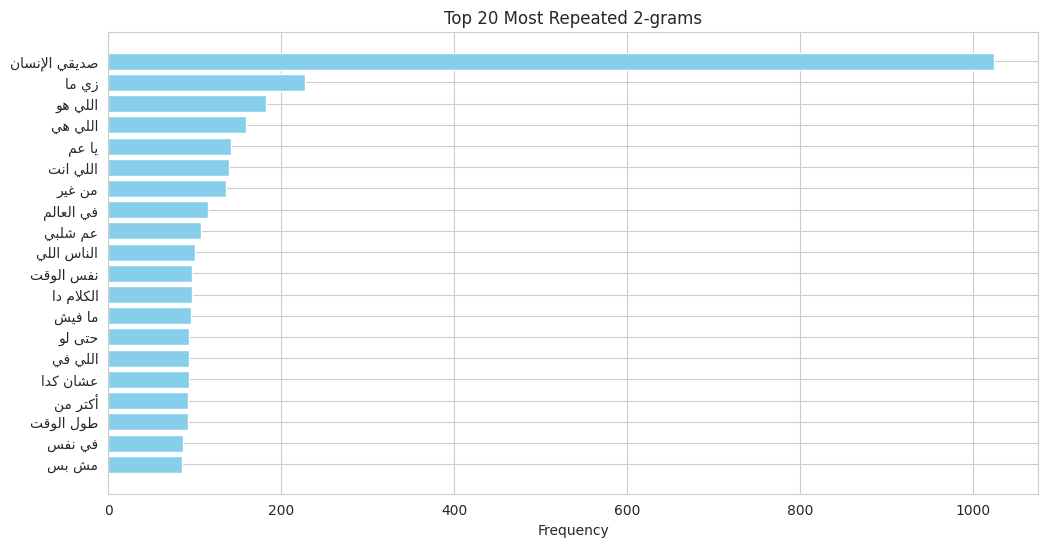

In [86]:
generate_top_k_ngrams(hadara_df, column_name='episode_transcript', ngram=2, k=20)

/tmp/ipykernel_62774/3194910396.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



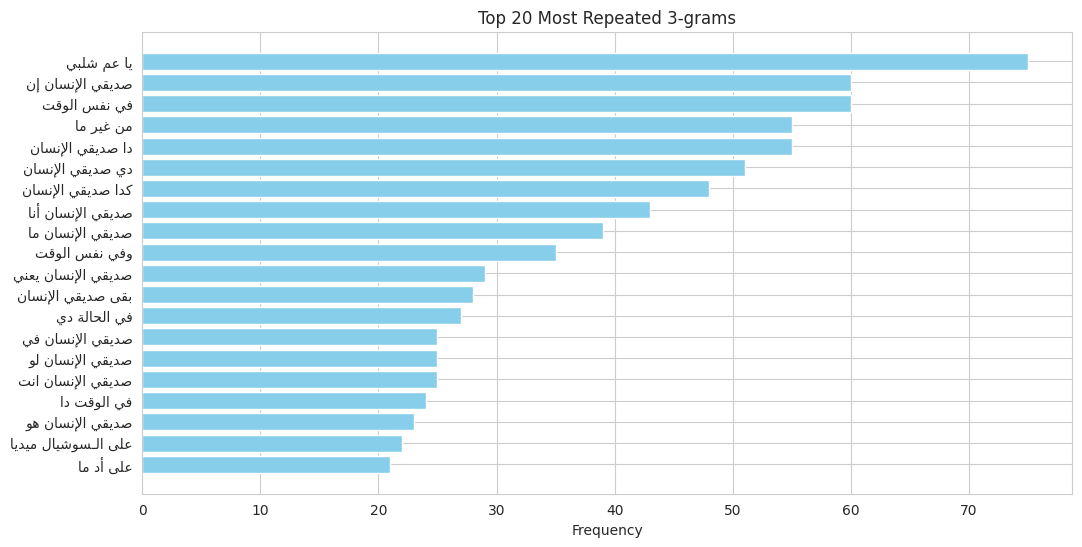

In [87]:
generate_top_k_ngrams(hadara_df, column_name='episode_transcript', ngram=3, k=20)

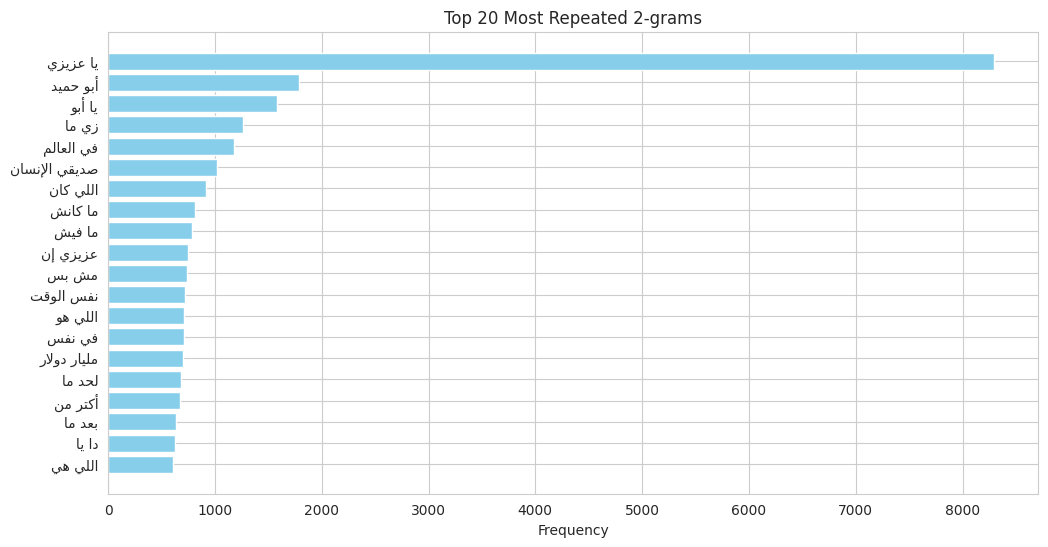

In [88]:
generate_top_k_ngrams(df, column_name='episode_transcript', ngram=2, k=20)

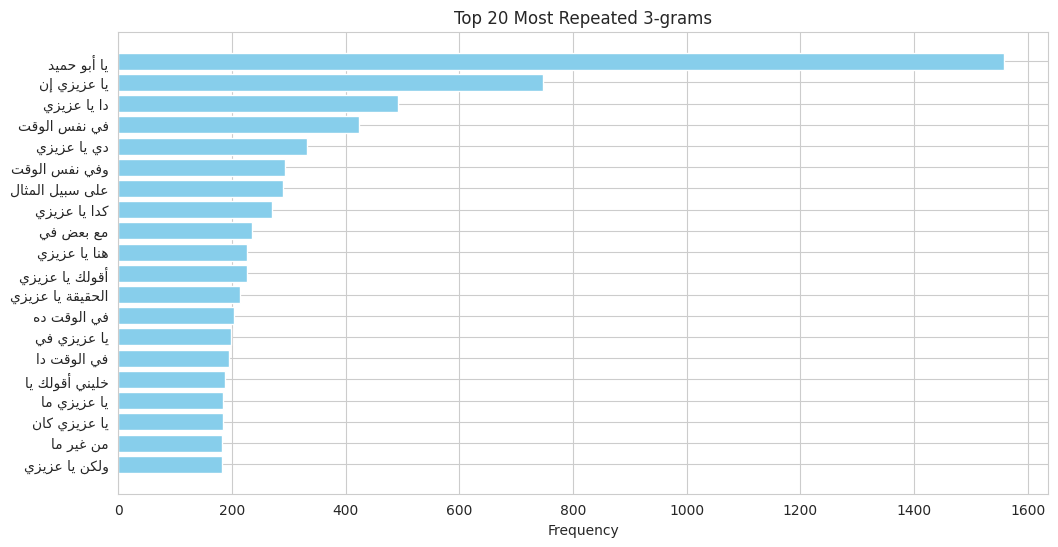

In [89]:
generate_top_k_ngrams(df, column_name='episode_transcript', ngram=3, k=20)

#### Topic Modelling

In [90]:
# Perform topic modeling using LDA using different number of topics and compute coherence scores
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# Example corpus
texts = [doc.split(" ") for doc in df['cleaned_transcript']]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append((num_topics, coherence_model.get_coherence()))
    return coherence_values

# Compute coherence for topic numbers between 2 and 10
coherence_scores = compute_coherence_values(dictionary, corpus, texts, start=2, limit=10, step=1)

# Print best number of topics
best_num_topics = max(coherence_scores, key=lambda x: x[1])[0]
print(f"Optimal number of topics: {best_num_topics}")


Optimal number of topics: 6


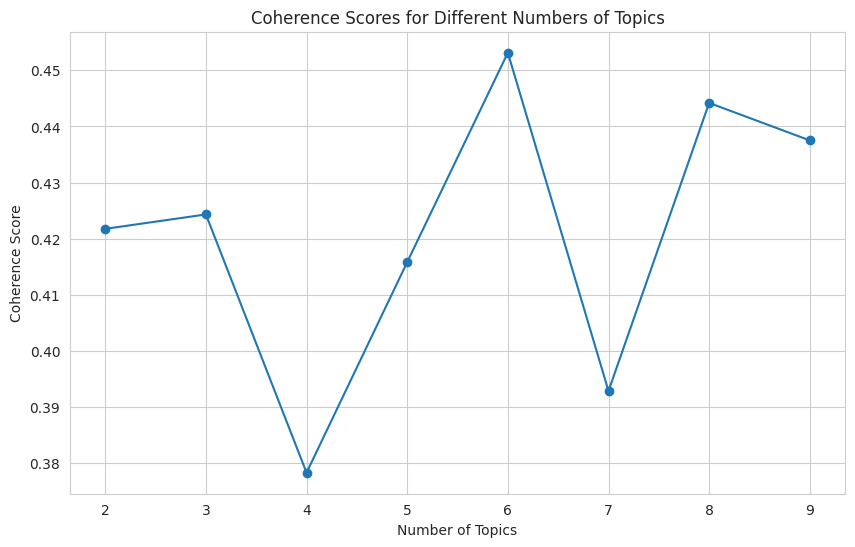

In [91]:
# Plot coherence scores
topics, coherence = zip(*coherence_scores)
plt.figure(figsize=(10, 6))
plt.plot(topics, coherence, marker='o')
plt.title("Coherence Scores for Different Numbers of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

In [ ]:
# Train LDA with the optimal number of topics and print the top words for each topic
num_topics = best_num_topics
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Print topics with the top words
topics = lda_model.print_topics(num_words=5)
for topic_id, topic in topics:
    print(f"Topic {topic_id}: {topic}")

Topic 0: 0.006*"الاسرائيلي" + 0.005*"الاسرائيليين" + 0.004*"الامريكيه" + 0.004*"الامريكي" + 0.003*"غزه"
Topic 1: 0.003*"الناس" + 0.003*"العالم" + 0.003*"جد" + 0.002*"الإنسان" + 0.002*"لحد"
Topic 2: 0.004*"الإنسان" + 0.004*"الناس" + 0.003*"العالم" + 0.002*"جد" + 0.002*"كتير"
Topic 3: 0.003*"الناس" + 0.003*"الإنسان" + 0.002*"جد" + 0.002*"كتير" + 0.002*"الصين"
Topic 4: 0.004*"العالم" + 0.003*"روسيا" + 0.003*"الصين" + 0.003*"السوق" + 0.003*"المهم"
Topic 5: 0.003*"الناس" + 0.003*"العالم" + 0.003*"الإنسان" + 0.002*"كتير" + 0.002*"جد"


### 3. Data Preprocessing

In [1]:
import pandas as pd 
import re
import pyarabic.araby as araby

In [7]:
# Load the data
df_sentiment = pd.read_csv("data/walid_sentiment_cleaned_data.csv")
df = pd.read_csv("./data/sarcasm.csv")
df['sentiment_score'] = df_sentiment['sentiment_score']
df = df.drop(columns=['tags'])
df.head()

episode_transcript                 creator  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  Al_Mokhbir_Al_Eqtisadi   
1  الراجل دا أنا عمري ما شفت حد زيه قبل كدا\nتحس ...  Al_Mokhbir_Al_Eqtisadi   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  Al_Mokhbir_Al_Eqtisadi   
3  في اواخر شهر سبتمبر سنه 2023 وزير\nالماليه الن...  Al_Mokhbir_Al_Eqtisadi   
4  في الساعات الاولى من صباح يوم 31 مايو\nسنه 201...  Al_Mokhbir_Al_Eqtisadi   

     length   sarcasm  sentiment_score  
0  00:22:52  غير ساخر         0.433861  
1  00:14:45  غير ساخر         0.751848  
2  00:16:53      ساخر         0.006446  
3  00:24:44      ساخر         0.070738  
4  00:14:11  غير ساخر         0.249777

In [8]:
# Cleaning function
from scripts.all_stopwords import all_stopwords

 
arabic_stopwords = list(all_stopwords)
def clean_arabic_txt(text: str) -> str:
    """
    Cleans Arabic text by removing timestamps, special tags, numbers, punctuation,
    ellipses, quotations, and unnecessary diacritics while preserving words.
    """
    # Remove timestamps (e.g., 5.127: or 11.167:)
    text = re.sub(r'^\d+\.\d+:\s*', '', text)  

    # Remove special tags like [موسيقى], [ضحك], etc.
    text = re.sub(r'\[.*?\]', '', text)  

    # Remove numbers
    text = re.sub(r'\d+', '', text)     

    # Remove ellipses (...)
    text = re.sub(r'\.{2,}', '', text)  

    # Separate punctuation & quotations from words by adding spaces around them
    text = re.sub(r'([^\w\s])', r' \1 ', text)  

    # Remove all punctuation, including quotations
    text = re.sub(r'[^\w\s]', '', text)  

    # # Remove english characters
    text = re.sub(r'[a-zA-Z]', '', text)

    # Remove Tashkeel (diacritics) and Tatweel (elongation)
    text = araby.strip_tashkeel(text)  
    text = araby.strip_tatweel(text)  

    # Trim and remove stopwords
    text = text.strip()
    text = ' '.join([word for word in text.split() if word not in arabic_stopwords])

    return text

# Apply the cleaning function to the episode transcripts
df['cleaned_transcript'] = df['episode_transcript'].apply(clean_arabic_txt)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/karimgamaleldin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


episode_transcript                 creator  \
0  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  Al_Mokhbir_Al_Eqtisadi   
1  الراجل دا أنا عمري ما شفت حد زيه قبل كدا\nتحس ...  Al_Mokhbir_Al_Eqtisadi   
2  في نوفمبر سنه 1971 وزراء ماليه مجموعه\nالدول ا...  Al_Mokhbir_Al_Eqtisadi   
3  في اواخر شهر سبتمبر سنه 2023 وزير\nالماليه الن...  Al_Mokhbir_Al_Eqtisadi   
4  في الساعات الاولى من صباح يوم 31 مايو\nسنه 201...  Al_Mokhbir_Al_Eqtisadi   

     length   sarcasm  sentiment_score  \
0  00:22:52  غير ساخر         0.433861   
1  00:14:45  غير ساخر         0.751848   
2  00:16:53      ساخر         0.006446   
3  00:24:44      ساخر         0.070738   
4  00:14:11  غير ساخر         0.249777   

                                  cleaned_transcript  
0  عمان وقطر والبحرين والسعوديه الدول العربيه الا...  
1  الراجل عمري شفت زيه تحس عبارة مزيج خليط توماس ...  
2  وزراء ماليه مجموعه الدول العشر الكبرى الجي اجت...  
3  اواخر وزير الماليه النيجيري اديبايو اووي ايدون...  
4  الساعات وتحديدا الساعه فجرا قوات كوماندوز اسرا...

In [65]:
import pandas as pd
from farasa.segmenter import FarasaSegmenter
from tqdm import tqdm

farasa_segmenter = FarasaSegmenter(interactive=True)

def tokenize_episode(episode: str) -> list:
    """
    Tokenizes a single Arabic text string using Farasa and cleans the tokens.
    
    Args:
        episode (str): An Arabic text string.
        
    Returns:
        list: A list of cleaned tokens.
    """
    segmented_episode = farasa_segmenter.segment(episode)
    episode_split = segmented_episode.split()
    episode_tokenized = []
    for word in episode_split:
        if '+' in word:
            # Split tokens further if needed
            word_split = word.split('+')
            episode_tokenized.extend(word_split)
        else:
            episode_tokenized.append(word)
    return episode_tokenized

[2025-03-05 23:30:38,129 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [22]:
df = pd.read_csv("./data/tf_idf_classifications.csv")
df.head()

file_name  \
0                                          أطفال_غزة   
1  المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل_من_...   
2  المخبر_الاقتصادي___كيف_بنى_المهاجرون_المغاربيو...   
3  المخبر_الاقتصادي___كيف_تخطط_أمريكا_لمنع_تطور_ق...   
4  المخبر_الاقتصادي___كيف_سرقت_بريطانيا_كوه_نور_أ...   

                                  episode_transcript    length  \
0  بعد سبعه اشهر وانا لا اجرؤ على حذف شيء\nيخصك م...  00:00:35   
1  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  00:22:52   
2  على غير العادة وبدون أي مقدمات\nخلونا نبدأ الح...  00:20:44   
3  من حوالي السنتين\nوتحديداً في 3 ديسمبر 2020\nج...  00:14:52   
4  يوم 8 سبتمبر 2022\nتم إعلان وفاة ملكة بريطانيا...  00:14:54   

                                                tags                 creator  \
0  ['غزة', 'الدحيح', 'AJ+ عربي', 'Eldahih السليط'...  Al Mokhbir Al Eqtisadi   
1  ['اسرائيل', 'اشرف ابراهيم', 'البرلمان البريطان...  Al Mokhbir Al Eqtisadi   
2  ['الجزائر', 'المغرب العربي', 'المغرب الكبير', ...  Al Mokhbir Al Eqtisadi   
3  ['AMD', 'APPLE', 'CHINA', 'NVDA', 'QCOM', 'SEC...  Al Mokhbir Al Eqtisadi   
4  ['الملكة', 'الملكة إليزابيث', 'المملكة المتحدة...  Al Mokhbir Al Eqtisadi   

                                  cleaned_transcript  \
0  سبعه اشهر وانا اجرؤ حذف شيء يخصك ازيل تطبيقات ...   
1  عمان وقطر والبحرين والسعوديه الدول العربيه الا...   
2  العادة وبدون مقدمات خلونا نبدأ الحلقة وندخل ال...   
3  حوالي السنتين وتحديدا جون راتكليف مدير الاستخب...   
4  إعلان وفاة ملكة بريطانيا إليزبيث عمر يناهز الش...   

                                     classifications  \
0  ['امهات غزه', 'اطفال غزه', 'قتل الاطفال', 'رفح...   
1  ['العلاقات البريطانية الإسرائيلية', 'اللوبي ال...   
2  ['الهجرة المغاربية إلى فرنسا', 'الاستعمار الفر...   
3  ['الحرب التكنولوجية بين أمريكا والصين', 'صناعة...   
4  ['جوهرة كوه نور', 'الاستعمار البريطاني للهند',...   

       tf_idf_classifications  
0            عينكم, خلوا, قصه  
1  المحافظين, الاسرائيلي, حزب  
2  المغاربة, المغاربية, فرنسا  
3            الصين, دا, أشباه  
4            كوه, نور, الماسة

In [29]:
# View one of Da7ee7 episodes
episode = df[df['creator'] == 'Da7ee7']['cleaned_transcript'].iloc[0]
print(episode)

عمي بسيوني الايام راجل دلوقتي افتكرت عم بسيوني سامحني عم بسيوني بعدين استبدلتوني بالذكاء الاصطناعي وعشان ايه ايه اذكى تمام بيشربش سجاير المكتب اديك محتاج ولايس وسط الناس الخبره عمرها تيجي المكنه كمبيوتر الخبره الحقيقيه بتيجي الانسان صانع الكمبيوتر فيش احسن الذكاء الطبيعي الرضاع الطبيعي عسل جبل النحل الطبيعي الاصلي الجميل ارجوك عم بسيوني راجل شوف حل وشغل المكنه بسم الله الرحمن الرحيم خد بالك الخبره حاضر خذ الخلاصه انجز خد الزبده بتاعت الموضوع خذ الزيتونه بكل الخضار عايزه خطوه خطوه الموضوع سهل وبسيط حاجه جربت تدوس زرار الباور دوس زرار الباور اشتغلش ايه فيش تاني السخان بتاعك بايظ انا هصلحه اعرف بيصلح سخانات كويس اعزائي المشاهدين السلام عليكم ورحمه الله وبركاته اهلا حلقه جديده برنامج الدحيح تكنولوجيا جديده بيختاريها الانسان يسهل حياته بيظهر قلق جديد تبعات التكنولوجيا اعلى نمط حياه الانسان متعود فمثلا ابريل سنه مجموعه مدرسين الرياضيات ولايه واشنطن خرجوا مظاهره السماح للطلبه يستخدموا الات حاسبه مصاهره جايه قلق حقيقي الناس انتشار الاجهزه هتدمر القدرات الحسابيه الطلبه ويخلي مخهم يصدي المظاهرات

In [70]:
df['tokenized_transcript'] = df['cleaned_transcript'].apply(tokenize_episode)
df.head()

file_name  \
0                                          أطفال_غزة   
1  المخبر_الاقتصادي___كيف_أصبح_أصدقاء_إسرائيل_من_...   
2  المخبر_الاقتصادي___كيف_بنى_المهاجرون_المغاربيو...   
3  المخبر_الاقتصادي___كيف_تخطط_أمريكا_لمنع_تطور_ق...   
4  المخبر_الاقتصادي___كيف_سرقت_بريطانيا_كوه_نور_أ...   

                                  episode_transcript    length  \
0  بعد سبعه اشهر وانا لا اجرؤ على حذف شيء\nيخصك م...  00:00:35   
1  عمان وقطر والبحرين والسعوديه دي هي الدول\nالعر...  00:22:52   
2  على غير العادة وبدون أي مقدمات\nخلونا نبدأ الح...  00:20:44   
3  من حوالي السنتين\nوتحديداً في 3 ديسمبر 2020\nج...  00:14:52   
4  يوم 8 سبتمبر 2022\nتم إعلان وفاة ملكة بريطانيا...  00:14:54   

                                                tags                 creator  \
0  ['غزة', 'الدحيح', 'AJ+ عربي', 'Eldahih السليط'...  Al Mokhbir Al Eqtisadi   
1  ['اسرائيل', 'اشرف ابراهيم', 'البرلمان البريطان...  Al Mokhbir Al Eqtisadi   
2  ['الجزائر', 'المغرب العربي', 'المغرب الكبير', ...  Al Mokhbir Al Eqtisadi   
3  ['AMD', 'APPLE', 'CHINA', 'NVDA', 'QCOM', 'SEC...  Al Mokhbir Al Eqtisadi   
4  ['الملكة', 'الملكة إليزابيث', 'المملكة المتحدة...  Al Mokhbir Al Eqtisadi   

                                  cleaned_transcript  \
0  سبعه اشهر وانا اجرؤ حذف شيء يخصك ازيل تطبيقات ...   
1  عمان وقطر والبحرين والسعوديه الدول العربيه الا...   
2  العادة وبدون مقدمات خلونا نبدأ الحلقة وندخل ال...   
3  حوالي السنتين وتحديدا جون راتكليف مدير الاستخب...   
4  إعلان وفاة ملكة بريطانيا إليزبيث عمر يناهز الش...   

                                     classifications  \
0  ['امهات غزه', 'اطفال غزه', 'قتل الاطفال', 'رفح...   
1  ['العلاقات البريطانية الإسرائيلية', 'اللوبي ال...   
2  ['الهجرة المغاربية إلى فرنسا', 'الاستعمار الفر...   
3  ['الحرب التكنولوجية بين أمريكا والصين', 'صناعة...   
4  ['جوهرة كوه نور', 'الاستعمار البريطاني للهند',...   

       tf_idf_classifications  \
0            عينكم, خلوا, قصه   
1  المحافظين, الاسرائيلي, حزب   
2  المغاربة, المغاربية, فرنسا   
3            الصين, دا, أشباه   
4            كوه, نور, الماسة   

                                tokenized_transcript  
0  [سبع, ه, أشهر, و, أنا, اجرؤ, حذف, شيء, يخصك, ا...  
1  [عمان, و, قطر, و, ال, بحرين, و, السعودي, ه, ال...  
2  [ال, عاد, ة, و, ب, دون, مقدم, ات, خلو, نا, نبد...  
3  [حوالي, ال, سن, ت, ين, و, تحديد, ا, جون, راتكل...  
4  [إعلان, وفا, ة, ملك, ة, بريطانيا, إليزبيث, عمر...

In [71]:
df.to_csv("./data/final_df.csv", index=False)

In [ ]:
from arabert.preprocess import ArabertPreprocessor
from transformers import AutoTokenizer

def arabert_tokenize(text: str) -> List[str]:
    model_name = "aubmindlab/bert-base-arabertv2"
    arabert_prep = ArabertPreprocessor(model_name=model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    preprocessed_text = arabert_prep.preprocess(text)
    
    tokens = tokenizer.tokenize(preprocessed_text)
    
    return tokens